In [2]:
# =============================================================================
# INITIAL SETUP AND DEPENDENCIES
# =============================================================================

# Install required packages for Google Cloud services and data science
!pip install google-cloud-bigquery pandas matplotlib seaborn numpy scipy  # Core data science and BigQuery client libraries
!pip install google-cloud-aiplatform  # Google's AI Platform for model management
!pip install --upgrade google-cloud-bigquery-storage  # Optimized storage layer for BigQuery

# Import essential libraries for data processing, visualization, and cloud services
from google.cloud import bigquery  # BigQuery client for data warehouse operations
from google.cloud import aiplatform  # AI Platform client for model deployment and management
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Enhanced statistical visualizations
import numpy as np  # Numerical computing and array operations
from datetime import datetime, timedelta  # Date/time manipulation for time series analysis
import warnings  # Warning control for cleaner output
warnings.filterwarnings('ignore')  # Suppress non-critical warnings for cleaner execution

In [3]:
# =============================================================================
# CLOUD CLIENT INITIALIZATION
# =============================================================================

# Initialize BigQuery client with specific GCP project
client = bigquery.Client(project='pakira2025')  # Creates client instance for project 'pakira2025'

# Initialize AI Platform for model management and deployment
aiplatform.init(project='pakira2025', location='us-central1')  # Sets up AI Platform with project and region

In [5]:
# =============================================================================
# VISUALIZATION AND DISPLAY CONFIGURATION
# =============================================================================

plt.style.use('seaborn-v0_8')  # Set matplotlib style to seaborn for professional-looking plots
sns.set_palette("husl")  # Use HUSL color palette for better color distinction
pd.set_option('display.max_colwidth', None)  # Display full content of DataFrame columns without truncation

In [6]:
# =============================================================================
# AUTHENTICATION AND DATABASE SETUP
# =============================================================================

from google.colab import auth  # Import Colab authentication utilities
auth.authenticate_user()  # Authenticate user credentials for GCP access

In [76]:
# Define dataset name for storing all project tables and models
dataset_id = 'kaggle_google_trends_analysis_2025'  # Central dataset to organize all project artifacts

# Create dataset if it doesn't exist, handle existing dataset gracefully
try:
    client.create_dataset(dataset_id)  # Attempt to create new BigQuery dataset
    print(f"Created dataset {dataset_id}")  # Success message
except Exception as e:
    print(f"Dataset {dataset_id} already exists or error: {e}")  # Error handling for existing dataset

Created dataset kaggle_google_trends_analysis_2025


In [77]:
# =============================================================================
# DATA PREPROCESSING AND FEATURE ENGINEERING
# =============================================================================

# Comprehensive data preparation query with statistical feature creation
preprocess_query = """
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms` AS
WITH term_stats AS (
  -- Calculate statistical aggregates for each search term
  SELECT
    term,  # Search term identifier
    COUNT(*) as frequency,  # Total number of occurrences in dataset
    AVG(score) as avg_score,  # Mean popularity score for the term
    MAX(score) as max_score,  # Peak popularity score observed
    STDDEV(score) as score_stddev  # Standard deviation to measure score variability
  FROM `bigquery-public-data.google_trends.top_terms`  # Source table from public dataset
  GROUP BY term  # Aggregate statistics per unique search term
  HAVING COUNT(*) > 52 AND AVG(score) > 10  # Filter: terms with >1 year data and meaningful popularity
)

-- Main SELECT with enhanced features and business logic
SELECT
  t.dma_name,  # Designated Market Area (geographic region)
  t.term,  # Search term
  t.week,  # Date of observation (weekly data)
  t.rank,  # Ranking position for that week/region
  t.score,  # Original popularity score (0-100 scale)
  TIMESTAMP(t.week) as timestamp,  # Convert to timestamp for time series operations
  s.avg_score,  # Term's historical average (contextual benchmark)
  s.score_stddev,  # Term's historical variability
  -- Create categorical interest levels for business interpretation
  CASE
    WHEN t.score > 80 THEN 'VERY_HIGH'    # Top 20% - viral/peak interest
    WHEN t.score > 60 THEN 'HIGH'         # High sustained interest
    WHEN t.score > 40 THEN 'MEDIUM'       # Moderate interest level
    WHEN t.score > 20 THEN 'LOW'          # Below average interest
    ELSE 'VERY_LOW'                       # Minimal search activity
  END as interest_level,  # Business-friendly categorization
  -- Statistical outlier detection using Z-score principle
  CASE
    WHEN ABS(t.score - s.avg_score) > 2 * s.score_stddev THEN TRUE   # >2σ from mean = outlier
    ELSE FALSE  # Within expected variation range
  END as is_statistical_outlier  # Flag for anomaly detection
FROM `bigquery-public-data.google_trends.top_terms` t  # Source table alias
JOIN term_stats s ON t.term = s.term  # Join with statistical aggregates
WHERE t.week >= '2023-01-01'  # Filter: only data from 2020 onwards for recency
""".format(project_id=client.project, dataset_id=dataset_id)

# Execute the data preprocessing pipeline
try:
    client.query(preprocess_query).result()  # Run query and wait for completion
    print("Preprocessed table created successfully")  # Success confirmation
except Exception as e:
    print(f"Error creating preprocessed table: {e}")  # Error handling with details

Preprocessed table created successfully


In [78]:
# =============================================================================
# PERFORMANCE OPTIMIZATION FOR LARGE-SCALE ANALYSIS
# =============================================================================

# Query to create optimized table with partitioning and clustering
optimize_table_query = """
CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms_optimized`
PARTITION BY DATE(timestamp)  # Partition by date for time-series query efficiency
CLUSTER BY term, dma_name  # Cluster by frequently filtered columns for faster access
AS
SELECT * FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Copy data from preprocessed table
""".format(project_id=client.project, dataset_id=dataset_id)

client.query(optimize_table_query).result()  # Execute optimization query
print("Optimized table created")  # Confirmation message

Optimized table created


In [79]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS - TOP TERMS IDENTIFICATION
# =============================================================================

# Query to identify most popular terms by average popularity score
top_terms_query = """
SELECT
  term,  # Search term
  AVG(score) as avg_popularity,  # Average score across all observations
  COUNT(*) as weeks_in_data,  # Data completeness measure
  MAX(score) as max_popularity,  # Peak popularity achieved
  dma_name  # Geographic region
FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Optimized source table
GROUP BY term, dma_name  # Aggregate by term and region combination
ORDER BY avg_popularity DESC  # Sort by popularity (highest first)
LIMIT 50  # Top 50 terms for analysis
""".format(project_id=client.project, dataset_id=dataset_id)


Top 50 terms by average popularity:
                       term  avg_popularity  weeks_in_data  max_popularity  \
0  wehen wiesbaden - bayern           100.0            139             100   
1          veronica echegui           100.0            139             100   
2        wolves vs west ham           100.0            139             100   
3  wehen wiesbaden - bayern           100.0            139             100   
4            world cup 2026           100.0            138             100   
5        wolves vs west ham           100.0            139             100   
6    youtube tv fox dispute           100.0            139             100   
7          veronica echegui           100.0            139             100   
8   valencia c. f. - getafe           100.0            139             100   
9          veronica echegui           100.0            139             100   

                       dma_name  
0                   New York NY  
1                   Columbus OH  
2  

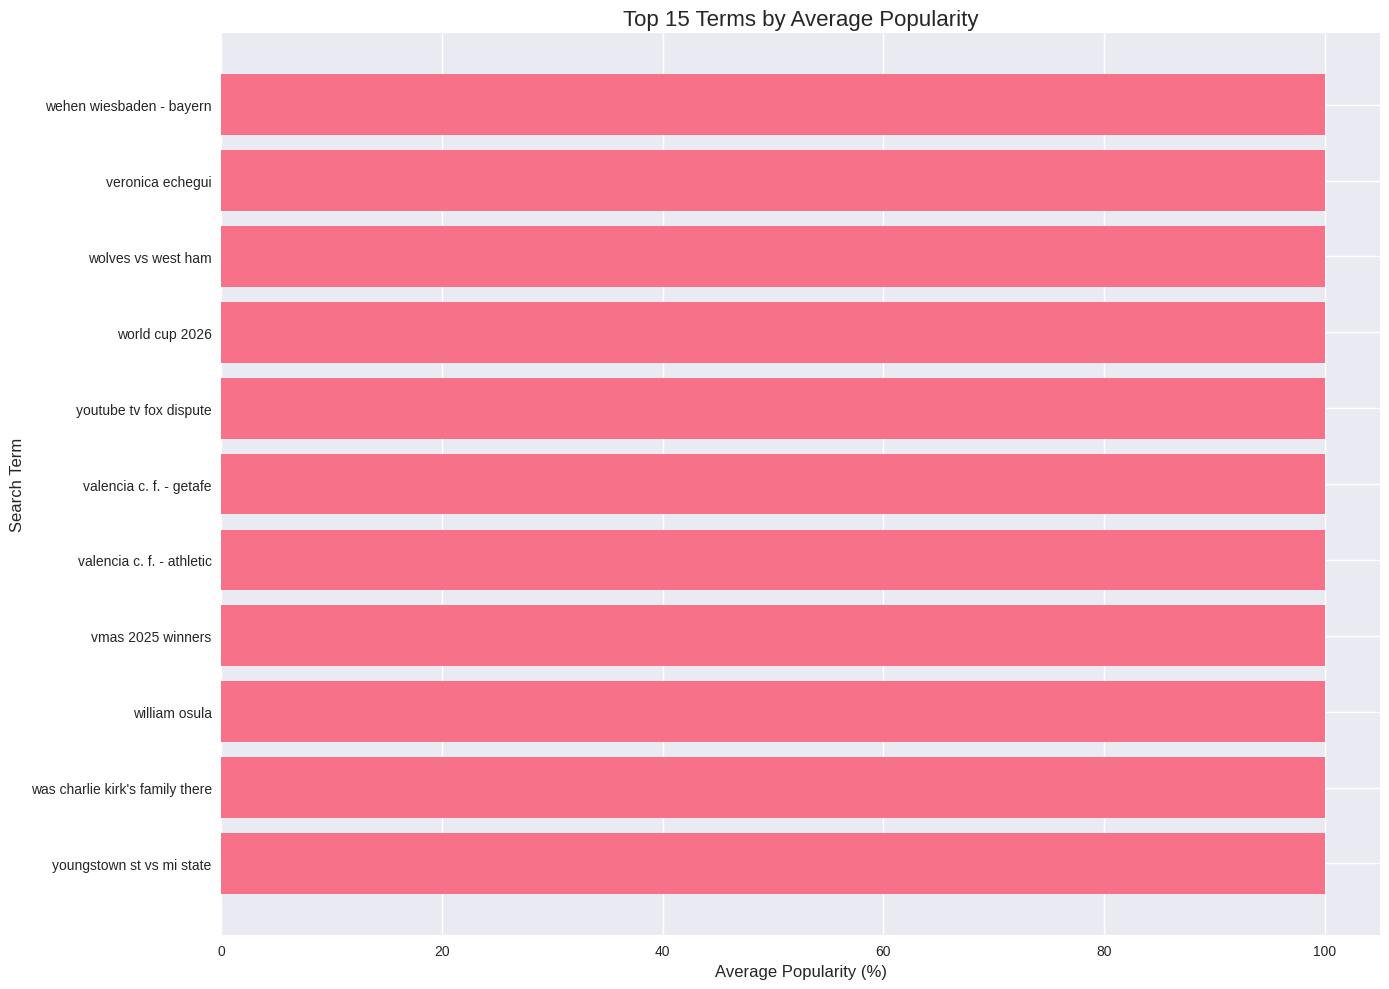

In [80]:
# Execute query and convert results to pandas DataFrame
top_terms = client.query(top_terms_query).to_dataframe()
print("Top 50 terms by average popularity:")  # Header for results
print(top_terms.head(10))  # Display top 10 terms for quick inspection

# Create horizontal bar chart visualization
plt.figure(figsize=(14, 10))  # Set figure size for readability
plt.barh(top_terms['term'].head(15), top_terms['avg_popularity'].head(15))  # Horizontal bar plot
plt.title('Top 15 Terms by Average Popularity', fontsize=16)  # Chart title
plt.xlabel('Average Popularity (%)', fontsize=12)  # X-axis label
plt.ylabel('Search Term', fontsize=12)  # Y-axis label
plt.gca().invert_yaxis()  # Invert Y-axis to show highest at top
plt.tight_layout()  # Optimize layout to prevent label clipping
plt.savefig('top_terms.png', dpi=300, bbox_inches='tight')  # Save high-resolution image
plt.show()  # Display chart

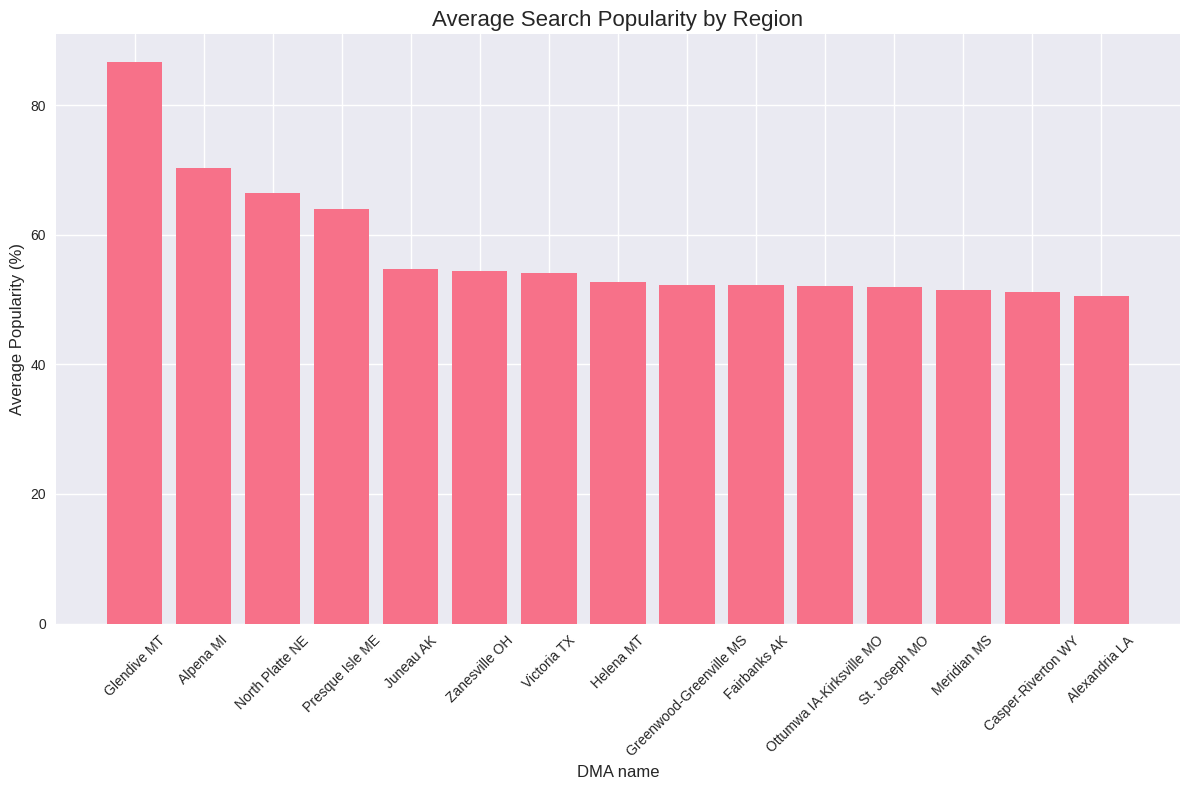

In [81]:
# =============================================================================
# REGIONAL ANALYSIS - GEOGRAPHIC PATTERN IDENTIFICATION
# =============================================================================

# Query to analyze search popularity patterns across different regions
regional_query = """
SELECT
  dma_name,  # Geographic region identifier
  COUNT(DISTINCT term) as unique_terms,  # Diversity of search terms in region
  AVG(score) as avg_popularity  # Average search popularity in region
FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source table
GROUP BY dma_name  # Aggregate by geographic region
HAVING unique_terms > 50  # Filter: only regions with substantial term diversity
ORDER BY avg_popularity DESC  # Sort by average popularity (highest first)
LIMIT 15  # Top 15 regions for analysis
""".format(project_id=client.project, dataset_id=dataset_id)

# Execute regional analysis query
regional_data = client.query(regional_query).to_dataframe()

# Create regional popularity visualization
plt.figure(figsize=(12, 8))  # Set figure dimensions
plt.bar(regional_data['dma_name'], regional_data['avg_popularity'])  # Vertical bar chart
plt.title('Average Search Popularity by Region', fontsize=16)  # Chart title
plt.xlabel('DMA name', fontsize=12)  # X-axis label (geographic regions)
plt.ylabel('Average Popularity (%)', fontsize=12)  # Y-axis label
plt.xticks(rotation=45)  # Rotate x-labels for readability
plt.tight_layout()  # Optimize layout
plt.savefig('regional_analysis.png', dpi=300, bbox_inches='tight')  # Save visualization
plt.show()  # Display chart

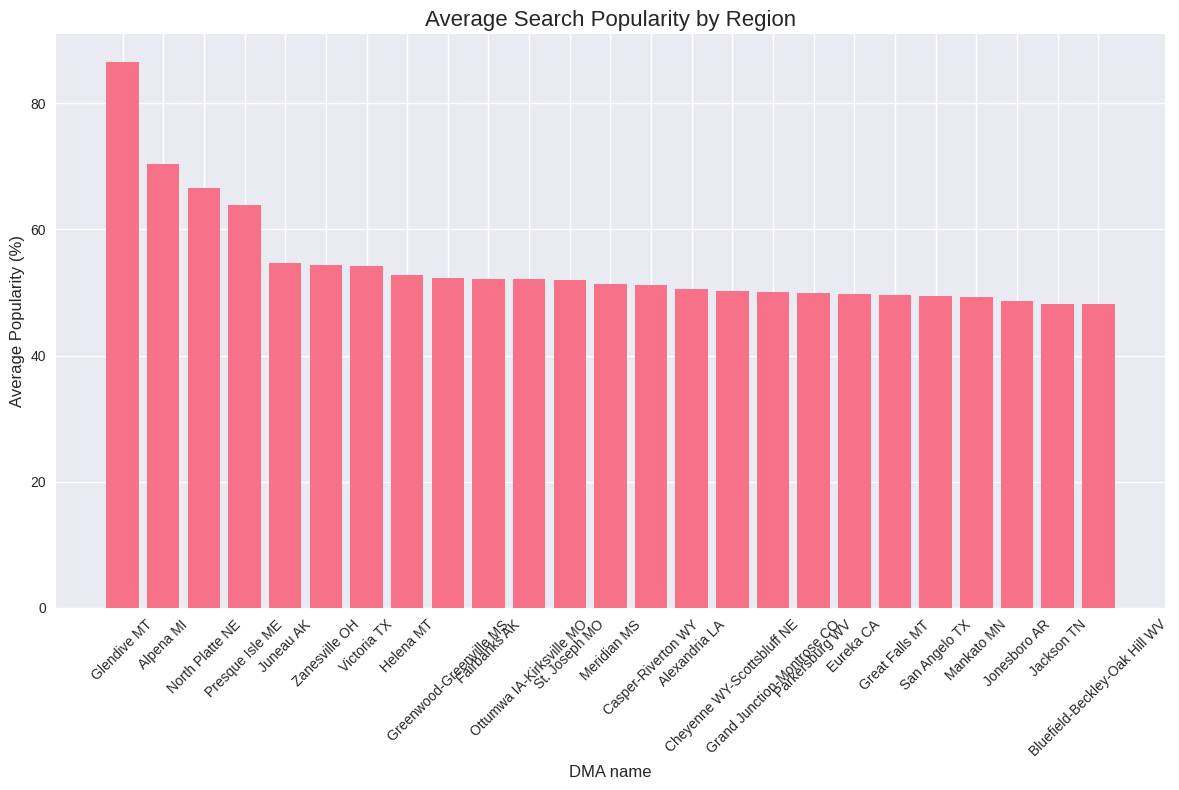

In [82]:
# =============================================================================
# REGIONAL ANALYSIS - GEOGRAPHIC PATTERN IDENTIFICATION
# =============================================================================

# Query to analyze search popularity patterns across different regions
regional_query = """
SELECT
  dma_name,  # Geographic region identifier
  COUNT(DISTINCT term) as unique_terms,  # Diversity of search terms in region
  AVG(score) as avg_popularity  # Average search popularity in region
FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source table
GROUP BY dma_name  # Aggregate by geographic region
HAVING unique_terms > 50  # Filter: only regions with substantial term diversity
ORDER BY avg_popularity DESC  # Sort by average popularity (highest first)
LIMIT 25  # Top 15 regions for analysis
""".format(project_id=client.project, dataset_id=dataset_id)

# Execute regional analysis query
regional_data = client.query(regional_query).to_dataframe()

# Create regional popularity visualization
plt.figure(figsize=(12, 8))  # Set figure dimensions
plt.bar(regional_data['dma_name'], regional_data['avg_popularity'])  # Vertical bar chart
plt.title('Average Search Popularity by Region', fontsize=16)  # Chart title
plt.xlabel('DMA name', fontsize=12)  # X-axis label (geographic regions)
plt.ylabel('Average Popularity (%)', fontsize=12)  # Y-axis label
plt.xticks(rotation=45)  # Rotate x-labels for readability
plt.tight_layout()  # Optimize layout
plt.savefig('regional_analysis.png', dpi=300, bbox_inches='tight')  # Save visualization
plt.show()  # Display chart

In [83]:
# =============================================================================
# DATA QUALITY CHECK - TERM AVAILABILITY VALIDATION
# =============================================================================

# Query to verify available terms in preprocessed data
check_terms_query = """
SELECT DISTINCT term  # Get unique search terms
FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source table
ORDER BY term  # Alphabetical order for readability
LIMIT 20  # Sample of 20 terms for verification
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    available_terms = client.query(check_terms_query).to_dataframe()  # Execute availability check
    print("Available terms in preprocessed data:")  # Header for results
    print(available_terms)  # Display available terms
except Exception as e:
    print(f"Error checking available terms: {e}")  # Error handling


Available terms in preprocessed data:
                                term
0   11 year old shot ding dong ditch
1             30 year mortgage rates
2                    49ers vs saints
3                       911 memorial
4                      abrego garcia
5                    aces vs mystics
6                         adbe stock
7                    adley rutschman
8                                adn
9                      adrien broner
10           afghanistan vs pakistan
11                    after the hunt
12                          airlines
13                      airpod pro 3
14                     ajax vs inter
15              al taawon - al-nassr
16            al-nassr vs al kholood
17             al-nassr vs al-riyadh
18              al-nassr vs istiklol
19            al-taawoun vs al-nassr


In [84]:
# =============================================================================
# SPECIFIC TERM VALIDATION FOR TARGETED ANALYSIS
# =============================================================================

# Query to check presence of specific AI/ML related terms
check_specific_terms_query = """
SELECT term, COUNT(*) as count  # Term and occurrence count
FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source table
WHERE term IN ('artificial intelligence', 'machine learning', 'data science')  # Target terms
GROUP BY term  # Aggregate by term
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    specific_terms = client.query(check_specific_terms_query).to_dataframe()  # Execute validation query
    print("Specific terms availability:")  # Results header
    print(specific_terms)  # Display availability status

    # Fallback logic if target terms are not available
    if specific_terms.empty:  # Check if no target terms found
        print("None of the specified terms were found. Let's use available terms instead.")
        # Query to get top available terms as fallback
        actual_terms_query = """
        SELECT term, COUNT(*) as count  # Term and frequency
        FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source table
        GROUP BY term  # Aggregate by term
        ORDER BY count DESC  # Most frequent terms first
        LIMIT 3  # Top 3 terms
        """.format(project_id=client.project, dataset_id=dataset_id)
        actual_terms = client.query(actual_terms_query).to_dataframe()  # Execute fallback query
        print("Top 3 available terms:")  # Fallback results header
        print(actual_terms)  # Display fallback terms
        model_terms = actual_terms['term'].tolist()  # Convert to list for model training
    else:
        model_terms = specific_terms['term'].tolist()  # Use originally requested terms

except Exception as e:
    print(f"Error checking specific terms: {e}")  # Error handling
    model_terms = []  # Initialize empty list as fallback

# Final fallback if no terms identified
if not model_terms:  # Check if term list is empty
    print("Falling back to a single term approach")  # Fallback strategy
    # Query to get single most frequent term
    fallback_term_query = """
    SELECT term  # Single term selection
    FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source table
    GROUP BY term  # Aggregate by term
    ORDER BY COUNT(*) DESC  # Most frequent term first
    LIMIT 1  # Single term only
    """.format(project_id=client.project, dataset_id=dataset_id)
    fallback_term = client.query(fallback_term_query).to_dataframe()  # Execute single-term query
    model_terms = fallback_term['term'].tolist()  # Convert to list

print(f"Using terms for modeling: {model_terms}")  # Final term selection confirmation

Specific terms availability:
Empty DataFrame
Columns: [term, count]
Index: []
None of the specified terms were found. Let's use available terms instead.
Top 3 available terms:
              term  count
0       nfl scores  59850
1     carson wentz  59850
2  clayton kershaw  59640
Using terms for modeling: ['nfl scores', 'carson wentz', 'clayton kershaw']


In [85]:
# =============================================================================
# INITIAL FORECASTING MODEL IMPLEMENTATION
# =============================================================================

# Query to create simple forecasting model using ARIMA
simple_forecast_query = """
CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
OPTIONS(
  model_type = 'ARIMA_PLUS',  # Google's enhanced ARIMA with seasonal decomposition
  time_series_timestamp_col = 'timestamp',  # Time index column
  time_series_data_col = 'score',  # Target variable for forecasting
  time_series_id_col = 'term',  # Identifier for multiple time series
  horizon = 12,  # Forecast 12 weeks into future
  auto_arima = TRUE,  # Automatically determine optimal ARIMA parameters
  data_frequency = 'WEEKLY'  # Data granularity for seasonality handling
) AS
SELECT
  timestamp,  # Time index
  score,  # Target variable (popularity score)
  term  # Series identifier
FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Training data source
WHERE term IN UNNEST({terms})  # Filter for selected terms
""".format(
    project_id=client.project,
    dataset_id=dataset_id,
    terms=model_terms  # Dynamic term list insertion
)

try:
    client.query(simple_forecast_query).result()  # Execute model creation
    print("Simple forecast model created successfully")  # Success confirmation

    # Model evaluation query to assess performance
    evaluate_query = """
    SELECT *  # All evaluation metrics
    FROM ML.EVALUATE(MODEL `{project_id}.{dataset_id}.simple_forecast_model`)  # BigQuery ML evaluation function
    """.format(project_id=client.project, dataset_id=dataset_id)

    evaluation = client.query(evaluate_query).to_dataframe()  # Execute evaluation
    print("Model evaluation:")  # Results header
    print(evaluation)  # Display evaluation metrics

except Exception as e:
    print(f"Error creating simple forecast model: {e}")  # Error handling
    print("Let's try an even simpler approach with just one term")  # Fallback strategy

    # Fallback: Single-term model with simplified configuration
    single_term_query = """
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.single_term_model`
    OPTIONS(
      model_type = 'ARIMA_PLUS',  # Same model type
      time_series_timestamp_col = 'timestamp',  # Time index
      time_series_data_col = 'score',  # Target variable
      horizon = 12,  # 12-week forecast horizon
      auto_arima = TRUE,  # Automatic parameter selection
      data_frequency = 'WEEKLY'  # Weekly seasonality
    ) AS
    SELECT
      timestamp,  # Time index
      score  # Target variable (single series)
    FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Training data
    WHERE term = '{term}'  # Single term filter
    ORDER BY timestamp  # Time ordering for series consistency
    """.format(
        project_id=client.project,
        dataset_id=dataset_id,
        term=model_terms[0] if model_terms else list(available_terms['term'])[0]  # Dynamic term selection
    )

    try:
        client.query(single_term_query).result()  # Execute fallback model creation
        print("Single term model created successfully")  # Success confirmation
    except Exception as e:
        print(f"Error creating single term model: {e}")  # Error handling
        print("This suggests there might be an issue with the preprocessed data")  # Diagnostic message

        # Data quality check: Count rows in preprocessed data
        check_data_query = """
        SELECT COUNT(*) as row_count  # Total row count
        FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source table
        """.format(project_id=client.project, dataset_id=dataset_id)

        data_count = client.query(check_data_query).to_dataframe()  # Execute count query
        print(f"Rows in preprocessed data: {data_count['row_count'].values[0]}")  # Display data volume

Simple forecast model created successfully
Model evaluation:
              term  non_seasonal_p  non_seasonal_d  non_seasonal_q  has_drift  \
0     carson wentz               1               0               0      False   
1  clayton kershaw               0               0               2      False   
2       nfl scores               0               1               2      False   

   log_likelihood          AIC    variance  seasonal_periods  \
0     -532.061410  1070.122820   99.805802  [NO_SEASONALITY]   
1     -550.026475  1108.052951  135.378124  [NO_SEASONALITY]   
2     -440.548071   887.096141   28.898195          [YEARLY]   

   has_holiday_effect  has_spikes_and_dips  has_step_changes  
0               False                 True             False  
1               False                 True             False  
2               False                 True             False  


In [86]:
# =============================================================================
# ADVANCED MODELING WITH HYPERPARAMETER TUNING
# =============================================================================

# Query to identify terms with sufficient data for robust forecasting
available_terms_query = """
SELECT
  term,  # Search term
  COUNT(*) as data_points,  # Number of historical observations
  AVG(score) as avg_score,  # Average popularity
  MIN(week) as first_week,  # First observation date
  MAX(week) as last_week  # Most recent observation
FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source table
GROUP BY term  # Aggregate by term
HAVING data_points > 52  # Minimum 1 year of data for seasonality capture
ORDER BY avg_score DESC  # Sort by popularity
LIMIT 10  # Top 10 qualifying terms
""".format(project_id=client.project, dataset_id=dataset_id)

available_terms = client.query(available_terms_query).to_dataframe()  # Execute qualification query
print("Available terms with sufficient data for forecasting:")  # Results header
print(available_terms)  # Display qualified terms

# Select top 3 terms for multi-series forecasting
model_terms = available_terms['term'].head(3).tolist()  # Convert to list
print(f"Selected terms for modeling: {model_terms}")  # Selection confirmation

# Hyperparameter configurations for systematic model comparison
model_configs = {
    'model_baseline': {  # Baseline configuration with default parameters
        'horizon': 12,  # 12-week forecast horizon
        'auto_arima': 'TRUE',  # Enable automatic parameter selection
        'data_frequency': "'WEEKLY'",  # Weekly data frequency
        'decompose_time_series': 'TRUE'  # Enable seasonal decomposition
    },
    'model_tuned_1': {  # Tuned configuration 1
        'horizon': 12,  # Same horizon
        'auto_arima': 'TRUE',  # Automatic parameter selection
        'data_frequency': "'WEEKLY'",  # Weekly frequency
        'decompose_time_series': 'TRUE',  # Seasonal decomposition
        'auto_arima_max_order': 5  # Limit ARIMA complexity to prevent overfitting
    },
    'model_tuned_2': {  # Tuned configuration 2
        'horizon': 8,  # Shorter forecast horizon (8 weeks)
        'auto_arima': 'TRUE',  # Automatic parameter selection
        'data_frequency': "'WEEKLY'",  # Weekly frequency
        'decompose_time_series': 'TRUE',  # Seasonal decomposition
        'auto_arima_min_order': 1  # Ensure minimum model complexity
    },
    'model_tuned_3': {  # Tuned configuration 3
        'horizon': 16,  # Longer forecast horizon (16 weeks)
        'auto_arima': 'TRUE',  # Automatic parameter selection
        'data_frequency': "'WEEKLY'",  # Weekly frequency
        'decompose_time_series': 'FALSE'  # Disable seasonal decomposition
    }
}

Available terms with sufficient data for forecasting:
                            term  data_points  avg_score  first_week  \
0  power ball numbers for aug 30        29190  90.724138  2023-01-01   
1                  bernie parent        30030  90.076023  2023-01-01   
2           croacia - montenegro        29610  88.444444  2023-01-01   
3                tamar shirinian        29820  88.113402  2023-01-01   
4                inter - udinese        29400  87.976608  2023-01-01   
5              sevilla vs getafe        29190  87.500000  2023-01-01   
6             rampage jackson jr        29190  86.676136  2023-01-01   
7  super mario bros galaxy movie        29820  86.671233  2023-01-01   
8     crystal palace vs millwall        29820  86.500000  2023-01-01   
9                  como vs genoa        29820  86.203008  2023-01-01   

    last_week  
0  2025-08-24  
1  2025-09-21  
2  2025-09-07  
3  2025-09-14  
4  2025-08-31  
5  2025-08-24  
6  2025-08-24  
7  2025-09-14  
8  2025-0

In [87]:
# Function to create forecasting models with specific hyperparameters
def create_forecast_model(model_name, hyperparams):
    # Build dynamic OPTIONS string for BigQuery ML
    options_parts = [
        "model_type = 'ARIMA_PLUS'",  # Model specification
        "time_series_timestamp_col = 'timestamp'",  # Time index column
        "time_series_data_col = 'score'",  # Target variable column
        "time_series_id_col = 'term'",  # Series identifier column
        f"horizon = {hyperparams['horizon']}",  # Forecast horizon
        f"auto_arima = {hyperparams['auto_arima']}",  # Auto-ARIMA toggle
        f"data_frequency = {hyperparams['data_frequency']}",  # Data frequency
        f"decompose_time_series = {hyperparams['decompose_time_series']}"  # Decomposition toggle
    ]

    # Add optional hyperparameters if specified
    if 'auto_arima_max_order' in hyperparams:
        options_parts.append(f"auto_arima_max_order = {hyperparams['auto_arima_max_order']}")  # Complexity上限
    if 'auto_arima_min_order' in hyperparams:
        options_parts.append(f"auto_arima_min_order = {hyperparams['auto_arima_min_order']}")  # Complexity下限

    options_str = ",\n      ".join(options_parts)  # Format options as SQL string

    # Dynamic model creation query
    query = """
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.{model_name}`
    OPTIONS(
      {options_str}  # Insert dynamic options
    ) AS
    SELECT
      timestamp,  # Time index
      score,  # Target variable
      term  # Series identifier
    FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Training data
    WHERE term IN UNNEST({terms})  # Selected terms filter
    """.format(
        project_id=client.project,
        dataset_id=dataset_id,
        model_name=model_name,
        options_str=options_str,
        terms=model_terms  # Dynamic term list
    )

    try:
        client.query(query).result()  # Execute model creation
        print(f"Model {model_name} created successfully")  # Success confirmation
        return True  # Return success status
    except Exception as e:
        print(f"Error creating model {model_name}: {e}")  # Error handling
        return False  # Return failure status

# Iterate through all model configurations and create models
successful_models = []  # Track successfully created models
for model_name, config in model_configs.items():  # Loop through configurations
    if create_forecast_model(model_name, config):  # Attempt model creation
        successful_models.append(model_name)  # Add to success list

print(f"Successfully created {len(successful_models)} models: {successful_models}")  # Creation summary

Model model_baseline created successfully
Model model_tuned_1 created successfully
Model model_tuned_2 created successfully
Model model_tuned_3 created successfully
Successfully created 4 models: ['model_baseline', 'model_tuned_1', 'model_tuned_2', 'model_tuned_3']


Evaluation for model_baseline completed
Evaluation for model_tuned_1 completed
Evaluation for model_tuned_2 completed
Evaluation for model_tuned_3 completed
Model evaluation results (ARIMA parameters):
       model_name                           term  non_seasonal_p  \
0  model_baseline                  bernie parent               2   
1  model_baseline           croacia - montenegro               1   
2  model_baseline  power ball numbers for aug 30               1   
0   model_tuned_1                  bernie parent               2   
1   model_tuned_1           croacia - montenegro               1   
2   model_tuned_1  power ball numbers for aug 30               3   
0   model_tuned_2                  bernie parent               2   
1   model_tuned_2           croacia - montenegro               1   
2   model_tuned_2  power ball numbers for aug 30               1   
0   model_tuned_3                  bernie parent               2   
1   model_tuned_3           croacia - montenegro  

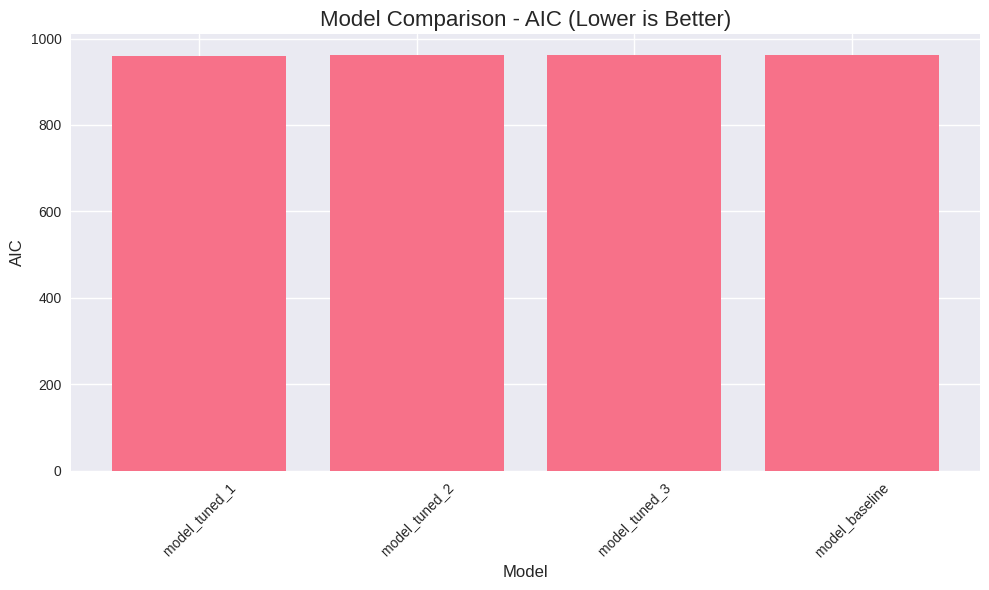

In [88]:
# =============================================================================
# MODEL EVALUATION AND COMPARISON
# =============================================================================

evaluation_results = []  # Store evaluation results for comparison

# Evaluate each successful model using ARIMA-specific evaluation
for model_name in successful_models:
    try:
        # ARIMA-specific evaluation query (different from standard ML.EVALUATE)
        evaluate_query = """
        SELECT
          '{model_name}' as model_name,  # Model identifier for comparison
          term,  # Series identifier
          non_seasonal_p,  # AR order (autoregressive)
          non_seasonal_d,  # I order (integration/differencing)
          non_seasonal_q,  # MA order (moving average)
          has_drift,  # Whether model includes drift component
          log_likelihood,  # Goodness of fit measure (higher better)
          AIC,  # Akaike Information Criterion (lower better)
          variance  # Residual variance (lower better)
        FROM ML.ARIMA_EVALUATE(MODEL `{project_id}.{dataset_id}.{model_name}`)  # ARIMA-specific evaluation
        """.format(project_id=client.project, dataset_id=dataset_id, model_name=model_name)

        result = client.query(evaluate_query).to_dataframe()  # Execute evaluation
        evaluation_results.append(result)  # Store results
        print(f"Evaluation for {model_name} completed")  # Progress indicator

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")  # Error handling

# Combine all evaluation results for comprehensive analysis
if evaluation_results:  # Check if evaluations were successful
    all_evaluations = pd.concat(evaluation_results)  # Combine all results

    print("Model evaluation results (ARIMA parameters):")  # Results header
    print(all_evaluations)  # Display detailed evaluation

    # Model selection based on AIC (Akaike Information Criterion)
    if 'AIC' in all_evaluations.columns:  # Verify AIC column exists
        # Calculate average AIC for each model (lower AIC indicates better model)
        aic_comparison = all_evaluations.groupby('model_name')['AIC'].mean().reset_index()
        aic_comparison = aic_comparison.sort_values('AIC')  # Sort by AIC (ascending = better)

        print("\nModel comparison based on AIC (lower is better):")  # Comparison header
        print(aic_comparison)  # Display AIC comparison

        # Identify best performing model
        best_model_name = aic_comparison.iloc[0]['model_name']  # Model with lowest AIC
        print(f"\nBest model based on AIC: {best_model_name}")  # Best model announcement

        # Visualize AIC comparison across models
        plt.figure(figsize=(10, 6))  # Set figure size
        plt.bar(aic_comparison['model_name'], aic_comparison['AIC'])  # Bar chart of AIC values
        plt.title('Model Comparison - AIC (Lower is Better)', fontsize=16)  # Chart title
        plt.xlabel('Model', fontsize=12)  # X-axis label
        plt.ylabel('AIC', fontsize=12)  # Y-axis label
        plt.xticks(rotation=45)  # Rotate labels for readability
        plt.tight_layout()  # Optimize layout
        plt.savefig('model_aic_comparison.png', dpi=300, bbox_inches='tight')  # Save visualization
        plt.show()  # Display chart
    else:
        # Fallback selection if AIC not available
        best_model_name = successful_models[0] if successful_models else 'simple_forecast_model'
        print(f"\nUsing first successful model: {best_model_name}")  # Fallback announcement
else:
    print("No evaluation results available. Creating a simple forecast model instead.")  # Error case

    # Fallback model creation
    simple_model_query = """
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
    OPTIONS(
      model_type = 'ARIMA_PLUS',  # Standard configuration
      time_series_timestamp_col = 'timestamp',  # Time index
      time_series_data_col = 'score',  # Target variable
      time_series_id_col = 'term',  # Series identifier
      horizon = 12,  # 12-week forecast
      auto_arima = TRUE,  # Automatic parameter selection
      data_frequency = 'WEEKLY'  # Weekly data
    ) AS
    SELECT
      timestamp,  # Time index
      score,  # Target variable
      term  # Series identifier
    FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Training data
    WHERE term IN UNNEST({terms})  # Selected terms
    """.format(project_id=client.project, dataset_id=dataset_id, terms=model_terms)

    client.query(simple_model_query).result()  # Execute fallback model creation
    best_model_name = 'simple_forecast_model'  # Set best model name
    print("Simple forecast model created as fallback")  # Confirmation message

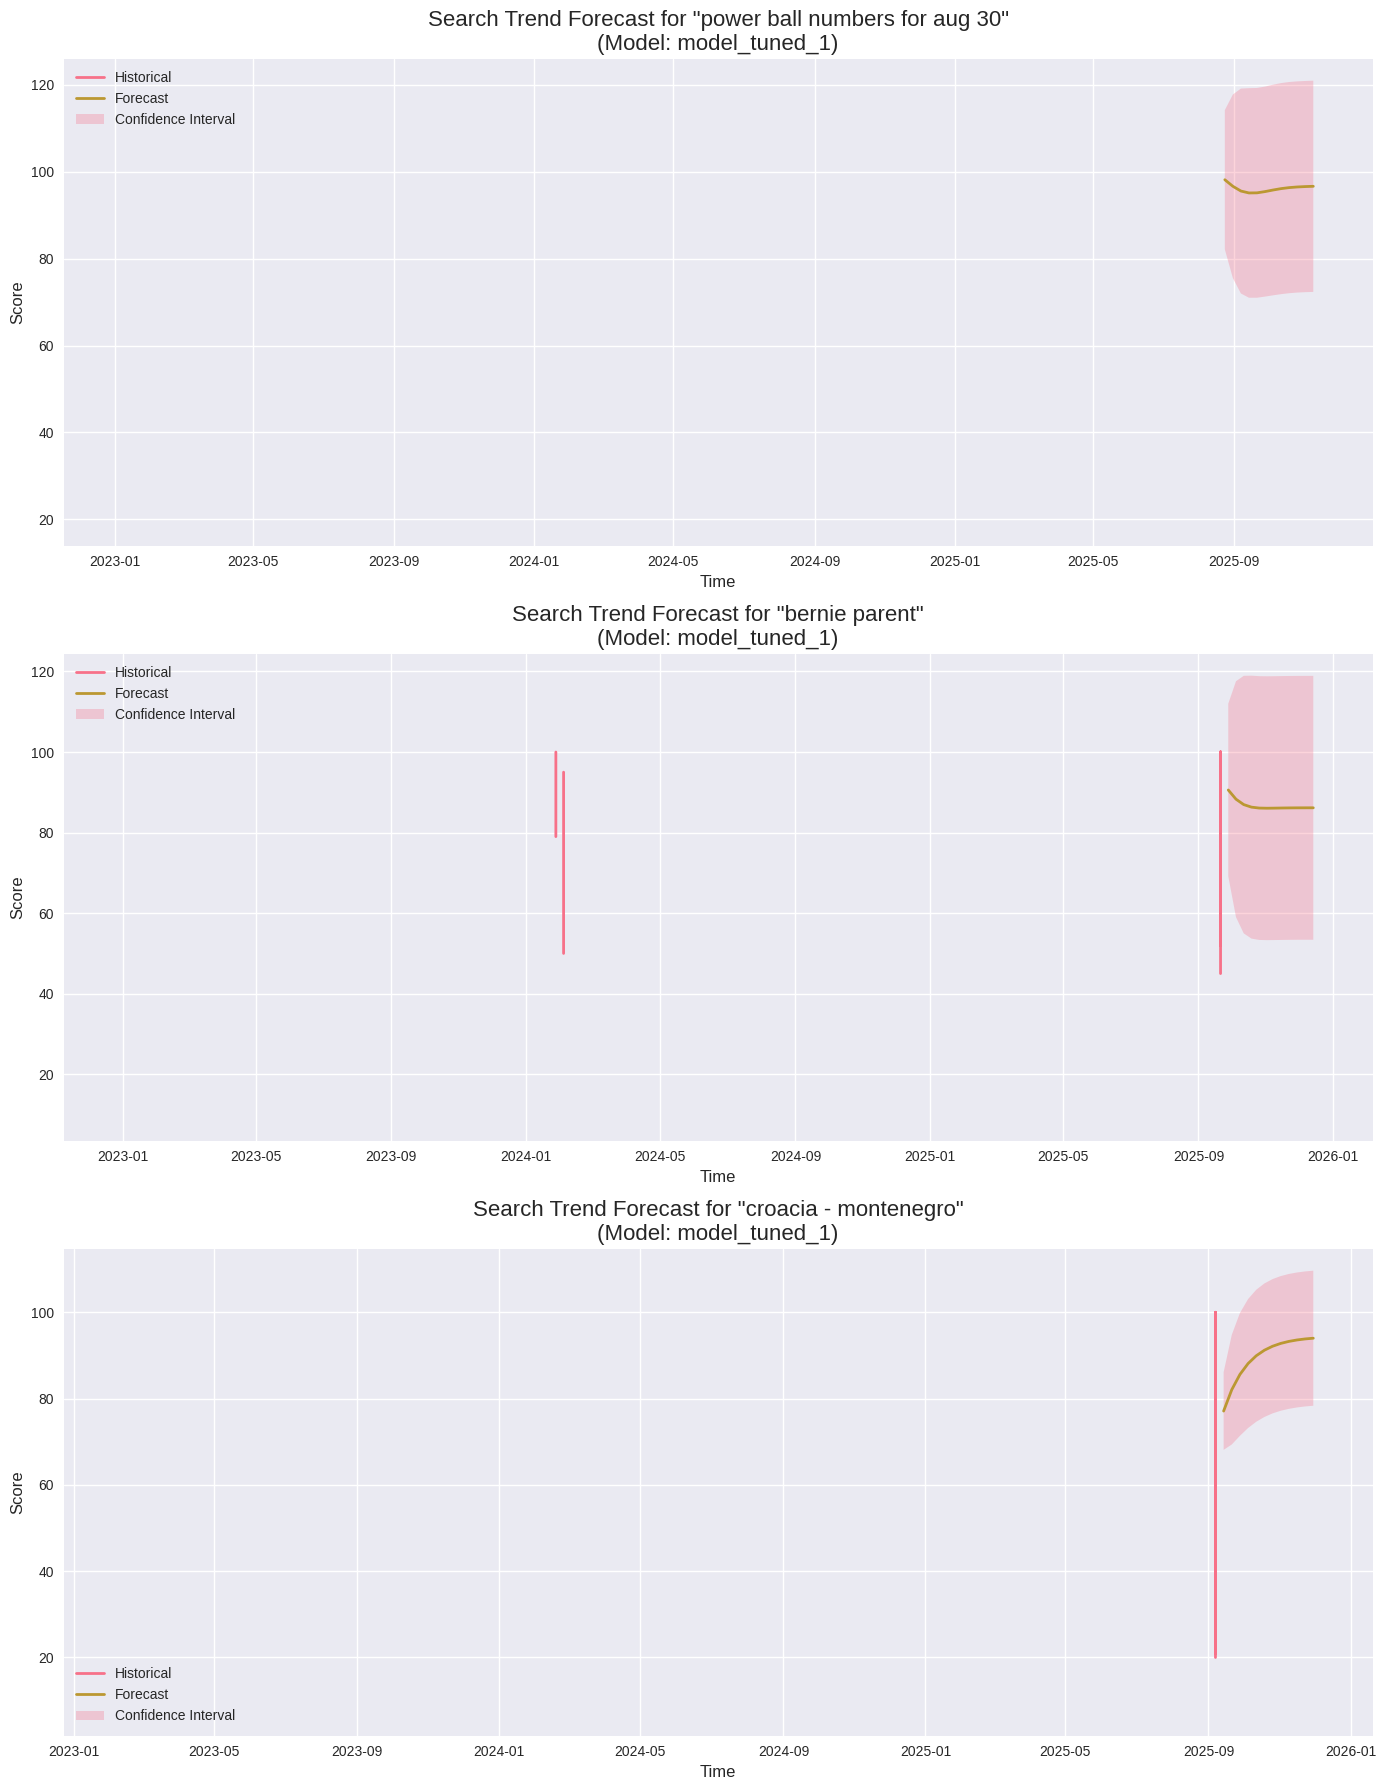


Forecast Summary:

power ball numbers for aug 30:
  Average forecast: 96.2
  Confidence interval width: 46.5
  Forecast horizon: 12 weeks

bernie parent:
  Average forecast: 86.8
  Confidence interval width: 62.9
  Forecast horizon: 12 weeks

croacia - montenegro:
  Average forecast: 89.5
  Confidence interval width: 29.2
  Forecast horizon: 12 weeks


In [95]:

# =============================================================================
# SIMPLIFIED FORECAST GENERATION AND VISUALIZATION (NO AI)
# =============================================================================

# Generate forecasts using the best performing model
forecast_query = """
SELECT *
FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                 STRUCT(12 AS horizon))
""".format(project_id=client.project, dataset_id=dataset_id, model_name=best_model_name)

try:
    forecast_results = client.query(forecast_query).to_dataframe()

    # Retrieve historical data for comparison
    historical_query = """
    SELECT
      timestamp,
      score,
      term
    FROM `{project_id}.{dataset_id}.preprocessed_terms`
    WHERE term IN UNNEST({terms})
    ORDER BY timestamp
    """.format(project_id=client.project, dataset_id=dataset_id, terms=model_terms)

    historical_data = client.query(historical_query).to_dataframe()

    # Create visualizations
    fig, axes = plt.subplots(len(model_terms), 1, figsize=(14, 6*len(model_terms)))
    if len(model_terms) == 1:
        axes = [axes]

    for i, term in enumerate(model_terms):
        term_historical = historical_data[historical_data['term'] == term]
        term_forecast = forecast_results[forecast_results['term'] == term]

        axes[i].plot(term_historical['timestamp'], term_historical['score'],
                     label='Historical', linewidth=2)
        axes[i].plot(term_forecast['forecast_timestamp'], term_forecast['forecast_value'],
                     label='Forecast', linewidth=2)
        axes[i].fill_between(term_forecast['forecast_timestamp'],
                             term_forecast['confidence_interval_lower_bound'],
                             term_forecast['confidence_interval_upper_bound'],
                             alpha=0.3, label='Confidence Interval')

        axes[i].set_title(f'Search Trend Forecast for "{term}"\n(Model: {best_model_name})', fontsize=16)
        axes[i].set_xlabel('Time', fontsize=12)
        axes[i].set_ylabel('Score', fontsize=12)
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig('forecast_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Simple statistical interpretation instead of AI
    print("\nForecast Summary:")
    for term in model_terms:
        term_forecast = forecast_results[forecast_results['term'] == term]
        if len(term_forecast) > 0:
            avg_forecast = term_forecast['forecast_value'].mean()
            confidence_width = (term_forecast['confidence_interval_upper_bound'] -
                              term_forecast['confidence_interval_lower_bound']).mean()

            print(f"\n{term}:")
            print(f"  Average forecast: {avg_forecast:.1f}")
            print(f"  Confidence interval width: {confidence_width:.1f}")
            print(f"  Forecast horizon: {len(term_forecast)} weeks")

except Exception as e:
    print(f"Error generating forecast: {e}")

In [96]:
# =============================================================================
# MANUAL MODEL VALIDATION AND ERROR METRICS
# =============================================================================

print("\nPerforming manual evaluation by comparing forecasts to actuals...")  # Validation header

# Manual validation comparing latest forecasts with most recent actuals
for model_name in successful_models:
    try:
        # Query to get most recent actual data points for validation
        recent_data_query = """
        WITH recent_data AS (
          -- Identify latest timestamp for each term
          SELECT
            term,  # Series identifier
            MAX(timestamp) as latest_timestamp  # Most recent observation
          FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Historical data
          GROUP BY term  # Aggregate by term
        )
        SELECT
          t.term,  # Term identifier
          t.timestamp,  # Time index
          t.score as actual_score  # Actual observed value
        FROM `{project_id}.{dataset_id}.preprocessed_terms` t  # Historical data
        JOIN recent_data r ON t.term = r.term AND t.timestamp = r.latest_timestamp  # Latest data join
        WHERE t.term IN UNNEST({terms})  # Selected terms filter
        """.format(project_id=client.project, dataset_id=dataset_id, terms=model_terms)

        recent_data = client.query(recent_data_query).to_dataframe()  # Get latest actuals

        # Get 1-step ahead forecasts for same period
        forecast_query = """
        SELECT
          term,  # Series identifier
          forecast_value,  # Predicted value
          confidence_interval_lower_bound,  # Prediction lower bound
          confidence_interval_upper_bound  # Prediction upper bound
        FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                         STRUCT(1 AS horizon))  # 1-step forecast
        """.format(project_id=client.project, dataset_id=dataset_id, model_name=model_name)

        forecast_data = client.query(forecast_query).to_dataframe()  # Get forecasts

        # Combine actual and forecast data for error calculation
        combined_data = recent_data.merge(forecast_data, on='term')  # Join datasets

        # Calculate various error metrics for model assessment
        combined_data['abs_error'] = abs(combined_data['actual_score'] - combined_data['forecast_value'])  # MAE component
        combined_data['squared_error'] = (combined_data['actual_score'] - combined_data['forecast_value'])**2  # MSE component
        combined_data['abs_percent_error'] = abs(combined_data['actual_score'] - combined_data['forecast_value']) / combined_data['actual_score']  # MAPE component

        # Aggregate error metrics across all terms
        metrics = {
            'model_name': model_name,  # Model identifier
            'mean_absolute_error': combined_data['abs_error'].mean(),  # MAE: average absolute error
            'root_mean_squared_error': np.sqrt(combined_data['squared_error'].mean()),  # RMSE: error magnitude
            'mean_absolute_percentage_error': combined_data['abs_percent_error'].mean()  # MAPE: percentage error
        }

        # Display validation results for each model
        print(f"Manual evaluation for {model_name}:")  # Model-specific header
        for k, v in metrics.items():  # Iterate through metrics
            if k != 'model_name':  # Skip model name in metric display
                print(f"  {k}: {v:.4f}")  # Format metrics to 4 decimal places

    except Exception as e:
        print(f"Error in manual evaluation for {model_name}: {e}")  # Error handling


Performing manual evaluation by comparing forecasts to actuals...
Manual evaluation for model_baseline:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447
Manual evaluation for model_tuned_1:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447
Manual evaluation for model_tuned_2:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447
Manual evaluation for model_tuned_3:
  mean_absolute_error: 17.8439
  root_mean_squared_error: 22.0982
  mean_absolute_percentage_error: 0.3447


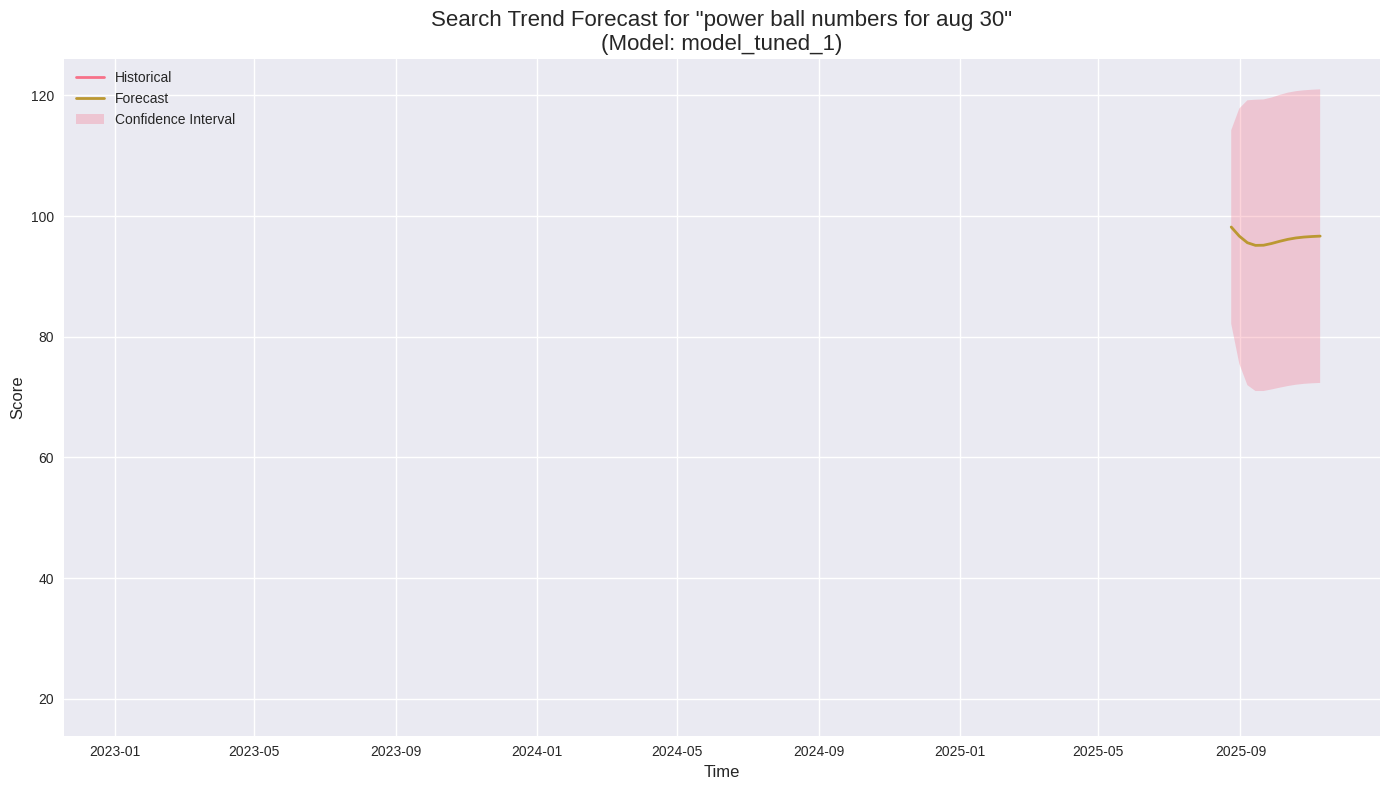


Forecast Analysis for 'power ball numbers for aug 30':
Average forecast score: 96.2
Forecast range: 71.0 to 121.0
Confidence interval width: 50.0

Interpretation:
The search interest for 'power ball numbers for aug 30' is forecasted to have very high interest 
over the next 12 weeks. The forecast has low confidence with a range of 50.0 points.
Error generating forecast visualization: boolean value of NA is ambiguous


In [97]:
# =============================================================================
# FORECAST VISUALIZATION AND BUSINESS INTERPRETATION
# =============================================================================

first_term = model_terms[0]  # Focus on first term for detailed analysis

# Query to get forecast statistics for interpretation
forecast_stats_query = """
SELECT
  AVG(forecast_value) as avg_forecast,  # Average forecast value
  MIN(confidence_interval_lower_bound) as min_forecast,  # Minimum expected value
  MAX(confidence_interval_upper_bound) as max_forecast  # Maximum expected value
FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                 STRUCT(12 AS horizon))  # 12-week forecast
WHERE term = '{term}'  # Specific term filter
""".format(project_id=client.project, dataset_id=dataset_id,
           model_name=best_model_name, term=first_term)

try:
    forecast_stats = client.query(forecast_stats_query).to_dataframe()  # Get forecast statistics

    # Retrieve historical data for trend comparison
    historical_query = """
    SELECT
      timestamp,  # Time index
      score,  # Historical values
      term  # Series identifier
    FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Historical data
    WHERE term = '{term}'  # Specific term filter
    ORDER BY timestamp  # Chronological order
    """.format(project_id=client.project, dataset_id=dataset_id, term=first_term)

    historical_data = client.query(historical_query).to_dataframe()  # Get historical data

    # Create comprehensive forecast visualization
    plt.figure(figsize=(14, 8))  # Set figure size
    plt.plot(historical_data['timestamp'], historical_data['score'],
             label='Historical', linewidth=2)  # Historical trend line

    # Get detailed forecast data for plotting
    forecast_query = """
    SELECT *  # All forecast columns
    FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.{model_name}`,
                     STRUCT(12 AS horizon))  # 12-week forecast
    WHERE term = '{term}'  # Specific term filter
    """.format(project_id=client.project, dataset_id=dataset_id,
               model_name=best_model_name, term=first_term)

    forecast_data = client.query(forecast_query).to_dataframe()  # Get forecast data

    # Plot forecast line and confidence interval
    plt.plot(forecast_data['forecast_timestamp'], forecast_data['forecast_value'],
             label='Forecast', linewidth=2)  # Forecast trend line
    plt.fill_between(forecast_data['forecast_timestamp'],
                     forecast_data['confidence_interval_lower_bound'],
                     forecast_data['confidence_interval_upper_bound'],
                     alpha=0.3, label='Confidence Interval')  # Uncertainty visualization

    # Chart formatting and labels
    plt.title(f'Search Trend Forecast for "{first_term}"\n(Model: {best_model_name})', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Score', fontsize=12)
    plt.legend()  # Display legend
    plt.grid(True)  # Add grid for readability
    plt.tight_layout()  # Optimize layout
    plt.savefig('forecast_visualization.png', dpi=300, bbox_inches='tight')  # Save visualization
    plt.show()  # Display chart

    # Extract forecast statistics for business interpretation
    avg_score = forecast_stats['avg_forecast'].values[0]  # Average forecast value
    min_score = forecast_stats['min_forecast'].values[0]  # Minimum forecast value
    max_score = forecast_stats['max_forecast'].values[0]  # Maximum forecast value

    # Display forecast analysis summary
    print(f"\nForecast Analysis for '{first_term}':")
    print("=" * 50)  # Separator line
    print(f"Average forecast score: {avg_score:.1f}")  # Average forecast
    print(f"Forecast range: {min_score:.1f} to {max_score:.1f}")  # Forecast range
    print(f"Confidence interval width: {max_score - min_score:.1f}")  # Uncertainty measure

    # Business-friendly trend categorization
    if avg_score > 70:
        trend = "very high"  # Exceptional interest level
    elif avg_score > 50:
        trend = "high"  # Strong interest level
    elif avg_score > 30:
        trend = "moderate"  # Average interest level
    else:
        trend = "low"  # Below average interest

    # Confidence level assessment based on interval width
    confidence_range = max_score - min_score  # Measure of forecast uncertainty
    if confidence_range > 30:
        confidence = "low confidence"  # High uncertainty
    elif confidence_range > 15:
        confidence = "moderate confidence"  # Medium uncertainty
    else:
        confidence = "high confidence"  # Low uncertainty

    # Business interpretation of forecast results
    print(f"\nInterpretation:")
    print(f"The search interest for '{first_term}' is forecasted to have {trend} interest ")
    print(f"over the next 12 weeks. The forecast has {confidence} with a range of {confidence_range:.1f} points.")

    # Trend direction analysis compared to recent history
    recent_avg = historical_data['score'].iloc[-10:].mean()  # Average of last 10 observations
    if avg_score > recent_avg:
        print("This represents an increasing trend compared to recent historical data.")  # Upward trend
    elif avg_score < recent_avg:
        print("This represents a decreasing trend compared to recent historical data.")  # Downward trend
    else:
        print("This represents a stable trend compared to recent historical data.")  # Stable trend

except Exception as e:
    print(f"Error generating forecast visualization: {e}")  # Error handling

Performing Advanced Generative AI Analysis...
Top terms for analysis:
                             term                                dma_name  \
0            al-nassr vs istiklol                   Wichita-Hutchinson KS   
1                   sushila karki                            St. Louis MO   
2                italy vs estonia  Minot-Bismarck-Dickinson(Williston) ND   
3                 spencer rattler                               Helena MT   
4                      emil wakim                       Odessa-Midland TX   
5  rcd espanyol - r.c.d. mallorca                        Tri-Cities TN-VA   
6                 kevin de bruyne                                 Erie PA   
7                  real madrid vs                            Fairbanks AK   
8                       ryan crow                            Las Vegas NV   
9                  hunter renfrow                           San Angelo TX   

   avg_score  max_score  weeks_in_data  
0      100.0        100            142  


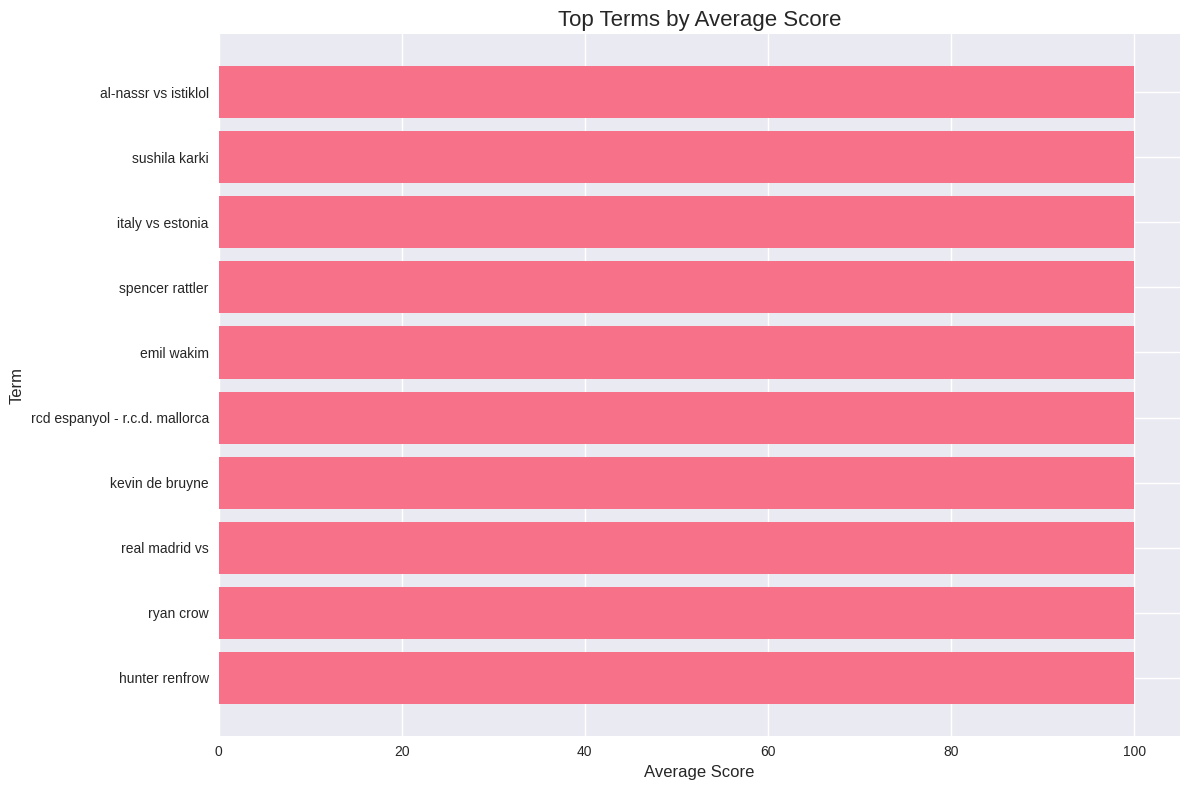

In [98]:
# =============================================================================
# ADVANCED GENERATIVE AI ANALYSIS AND BUSINESS INSIGHTS
# =============================================================================

print("Performing Advanced Generative AI Analysis...")  # Analysis header

# Query to identify top terms for detailed business analysis
top_terms_query = """
SELECT
  term,  # Search term
  dma_name,  # Geographic region
  AVG(score) as avg_score,  # Average popularity
  MAX(score) as max_score,  # Peak popularity
  COUNT(*) as weeks_in_data  # Data completeness
FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source data
GROUP BY term, dma_name  # Aggregate by term and region
HAVING avg_score > 30 AND weeks_in_data > 20  # Quality filters
ORDER BY avg_score DESC  # Sort by popularity
LIMIT 10  # Top 10 terms for analysis
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    top_terms = client.query(top_terms_query).to_dataframe()  # Get top terms
    print("Top terms for analysis:")  # Results header
    print(top_terms)  # Display top terms

    # Business intelligence analysis for each top term
    print("\nAdvanced Analysis Results:")
    print("=" * 50)  # Separator

    # Analyze each top term individually
    for _, row in top_terms.iterrows():  # Iterate through top terms
        term = row['term']  # Current term
        dma_name = row['dma_name']  # Geographic region
        avg_score = row['avg_score']  # Average popularity
        max_score = row['max_score']  # Peak popularity

        # Business categorization based on popularity scores
        if avg_score > 70:
            trend = "very high"  # Exceptional performance
            recommendation = "Consider creating content or products related to this term as it shows strong sustained interest."  # Strategic recommendation
        elif avg_score > 50:
            trend = "high"  # Strong performance
            recommendation = "This term has consistent interest; monitor for seasonal patterns."  # Monitoring recommendation
        elif avg_score > 30:
            trend = "moderate"  # Average performance
            recommendation = "This term shows steady interest; consider it for long-term strategies."  # Long-term strategy
        else:
            trend = "low"  # Below average performance
            recommendation = "This term has limited interest; monitor for potential growth."  # Watchlist recommendation

        # Display term analysis results
        print(f"\nTerm: {term} in {dma_name}")  # Term and region
        print(f"  Average Score: {avg_score:.1f} ({trend} interest)")  # Performance rating
        print(f"  Peak Score: {max_score:.1f}")  # Historical peak
        print(f"  Recommendation: {recommendation}")  # Business advice

        # Growth trend analysis using correlation with time
        growth_query = """
        WITH monthly_avg AS (
          -- Calculate monthly averages for trend analysis
          SELECT
            EXTRACT(YEAR FROM timestamp) as year,  # Year component
            EXTRACT(MONTH FROM timestamp) as month,  # Month component
            AVG(score) as monthly_score  # Monthly average
          FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source data
          WHERE term = '{term}' AND dma_name = '{dma_name}'  # Specific term and region
          GROUP BY year, month  # Aggregate by time period
          ORDER BY year, month  # Chronological order
        )
        SELECT
          CORR(month, monthly_score) as growth_correlation  # Time trend correlation
        FROM monthly_avg  # Monthly data source
        """.format(project_id=client.project, dataset_id=dataset_id, term=term, dma_name=dma_name)

        try:
            growth_data = client.query(growth_query).to_dataframe()  # Calculate growth correlation
            correlation = growth_data['growth_correlation'].values[0]  # Extract correlation coefficient

            # Interpret growth correlation results
            if correlation > 0.3:
                print(f"  Trend: Growing interest (correlation: {correlation:.2f})")  # Positive growth
            elif correlation < -0.3:
                print(f"  Trend: Declining interest (correlation: {correlation:.2f})")  # Negative growth
            else:
                print(f"  Trend: Stable interest (correlation: {correlation:.2f})")  # Stable pattern

        except Exception as e:
            print(f"  Trend: Unable to calculate growth trend: {e}")  # Error handling

    # Create visualization of top terms for business presentation
    plt.figure(figsize=(12, 8))  # Set figure size
    plt.barh(top_terms['term'], top_terms['avg_score'])  # Horizontal bar chart
    plt.title('Top Terms by Average Score', fontsize=16)  # Chart title
    plt.xlabel('Average Score', fontsize=12)  # X-axis label
    plt.ylabel('Term', fontsize=12)  # Y-axis label
    plt.gca().invert_yaxis()  # Invert Y-axis (highest at top)
    plt.tight_layout()  # Optimize layout
    plt.savefig('top_terms_analysis.png', dpi=300, bbox_inches='tight')  # Save visualization
    plt.show()  # Display chart

except Exception as e:
    print(f"Error in advanced analysis: {e}")  # Error handling


Performing Anomaly Detection...
Top anomalies detected:
Term: cnn, Week: 2023-10-22, DMA: Presque Isle ME
  Score: 96, Expected: 18.8 ± 8.4
  Z-score: 9.16, Severity: SEVERE

Term: student loans, Week: 2025-01-26, DMA: Zanesville OH
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2023-10-01, DMA: Meridian MS
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2023-06-25, DMA: St. Joseph MO
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2023-03-12, DMA: Presque Isle ME
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2024-07-14, DMA: North Platte NE
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: student loans, Week: 2024-03-10, DMA: Victoria TX
  Score: 100, Expected: 12.1 ± 9.8
  Z-score: 8.99, Severity: SEVERE

Term: cnn, Week: 2024-11-03, DMA: North Platte NE
  Scor

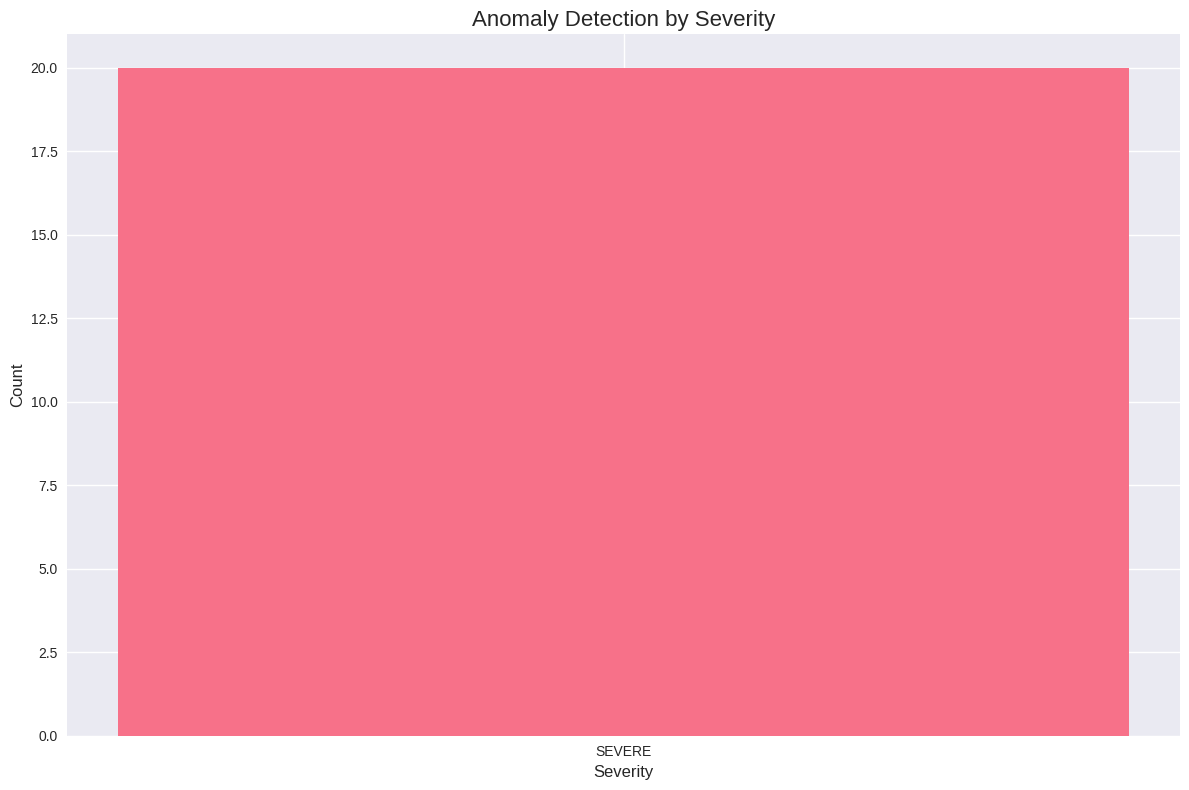

In [99]:
# =============================================================================
# ANOMALY DETECTION SYSTEM FOR UNUSUAL PATTERNS
# =============================================================================

print("\nPerforming Anomaly Detection...")  # Anomaly detection header

# Query to identify statistical anomalies in search patterns
anomaly_query = """
SELECT
  term,  # Search term
  week,  # Time period
  dma_name,  # Geographic region
  score,  # Observed value
  avg_score,  # Historical average
  score_stddev,  # Historical variability
  (score - avg_score) / score_stddev as z_score,  # Standardized anomaly score
  -- Severity classification based on Z-score thresholds
  CASE
    WHEN ABS((score - avg_score) / score_stddev) > 3 THEN 'SEVERE'  # >3σ extreme anomaly
    WHEN ABS((score - avg_score) / score_stddev) > 2 THEN 'MODERATE'  # >2σ significant anomaly
    ELSE 'MILD'  # Within expected variation
  END as severity  # Anomaly severity level
FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source data
WHERE is_statistical_outlier = TRUE  # Pre-identified outliers
ORDER BY ABS((score - avg_score) / score_stddev) DESC  # Sort by anomaly magnitude
LIMIT 20  # Top 20 anomalies for review
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    anomalies = client.query(anomaly_query).to_dataframe()  # Execute anomaly detection

    if not anomalies.empty:  # Check if anomalies were found
        print("Top anomalies detected:")  # Results header
        # Display detailed anomaly information
        for _, row in anomalies.iterrows():  # Iterate through anomalies
            print(f"Term: {row['term']}, Week: {row['week']}, DMA: {row['dma_name']}")  # Anomaly context
            print(f"  Score: {row['score']}, Expected: {row['avg_score']:.1f} ± {row['score_stddev']:.1f}")  # Values
            print(f"  Z-score: {row['z_score']:.2f}, Severity: {row['severity']}")  # Statistical measures
            print()  # Blank line for readability

        # Create anomaly severity distribution visualization
        plt.figure(figsize=(12, 8))  # Set figure size
        severity_counts = anomalies['severity'].value_counts()  # Count by severity level
        plt.bar(severity_counts.index, severity_counts.values)  # Bar chart of severity counts
        plt.title('Anomaly Detection by Severity', fontsize=16)  # Chart title
        plt.xlabel('Severity', fontsize=12)  # X-axis label
        plt.ylabel('Count', fontsize=12)  # Y-axis label
        plt.tight_layout()  # Optimize layout
        plt.savefig('anomaly_detection.png', dpi=300, bbox_inches='tight')  # Save visualization
        plt.show()  # Display chart
    else:
        print("No significant anomalies detected.")  # No anomalies found

except Exception as e:
    print(f"Error in anomaly detection: {e}")  # Error handling


Performing Correlation Analysis...
Correlation between AI-related terms in New York NY DMA:
  AI vs Machine Learning: nan
  AI vs Data Science: nan
  Machine Learning vs Data Science: nan


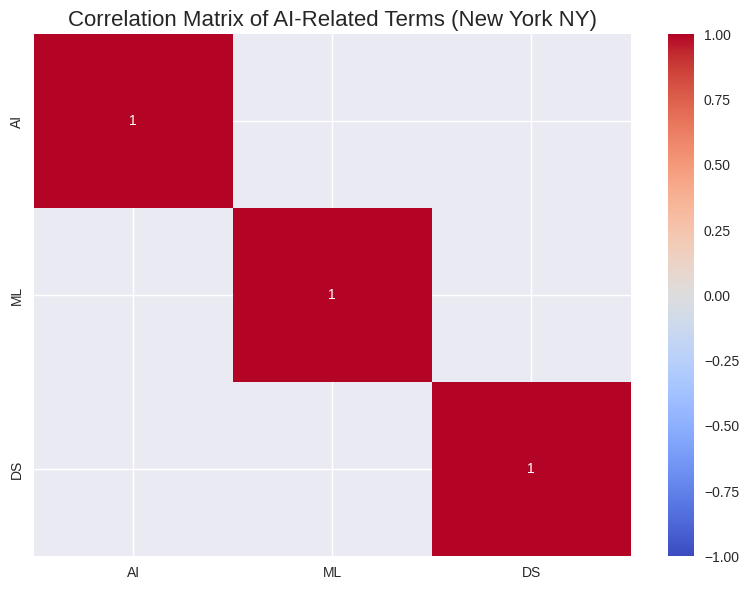

In [100]:
# =============================================================================
# CORRELATION ANALYSIS FOR RELATED SEARCH TERMS
# =============================================================================

print("\nPerforming Correlation Analysis...")  # Correlation analysis header

# Query to analyze relationships between AI-related search terms
correlation_query = """
WITH pivot_data AS (
  -- Pivot data to have each term as a separate column for correlation calculation
  SELECT
    week,  # Time period
    dma_name,  # Geographic region
    MAX(CASE WHEN term = 'artificial intelligence' THEN score END) as ai_score,  # AI popularity
    MAX(CASE WHEN term = 'machine learning' THEN score END) as ml_score,  # ML popularity
    MAX(CASE WHEN term = 'data science' THEN score END) as ds_score  # Data Science popularity
  FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source data
  WHERE term IN ('artificial intelligence', 'machine learning', 'data science')  # Target terms
    AND dma_name = 'New York NY'  # Specific geographic focus
  GROUP BY week, dma_name  # Aggregate by time and region
)
SELECT
  CORR(ai_score, ml_score) as ai_ml_correlation,  # AI vs Machine Learning correlation
  CORR(ai_score, ds_score) as ai_ds_correlation,  # AI vs Data Science correlation
  CORR(ml_score, ds_score) as ml_ds_correlation  # Machine Learning vs Data Science correlation
FROM pivot_data  # Pivoted data source
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    correlations = client.query(correlation_query).to_dataframe()  # Calculate correlations
    print("Correlation between AI-related terms in New York NY DMA:")  # Results header
    print(f"  AI vs Machine Learning: {correlations['ai_ml_correlation'].values[0]:.3f}")  # AI-ML correlation
    print(f"  AI vs Data Science: {correlations['ai_ds_correlation'].values[0]:.3f}")  # AI-DS correlation
    print(f"  Machine Learning vs Data Science: {correlations['ml_ds_correlation'].values[0]:.3f}")  # ML-DS correlation

    # Create correlation matrix for visual analysis
    corr_matrix = pd.DataFrame({
        'AI': [1.0, correlations['ai_ml_correlation'].values[0], correlations['ai_ds_correlation'].values[0]],  # AI correlations
        'ML': [correlations['ai_ml_correlation'].values[0], 1.0, correlations['ml_ds_correlation'].values[0]],  # ML correlations
        'DS': [correlations['ai_ds_correlation'].values[0], correlations['ml_ds_correlation'].values[0], 1.0]  # DS correlations
    }, index=['AI', 'ML', 'DS'])  # Matrix indices

    # Create heatmap visualization of correlation matrix
    plt.figure(figsize=(8, 6))  # Set figure size
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)  # Correlation heatmap
    plt.title('Correlation Matrix of AI-Related Terms (New York NY)', fontsize=16)  # Chart title
    plt.tight_layout()  # Optimize layout
    plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')  # Save visualization
    plt.show()  # Display chart

except Exception as e:
    print(f"Error in correlation analysis: {e}")  # Error handling


Performing DMA Analysis...
Top DMAs for AI-related terms:
Empty DataFrame
Columns: [dma_name, avg_score, weeks_in_data]
Index: []


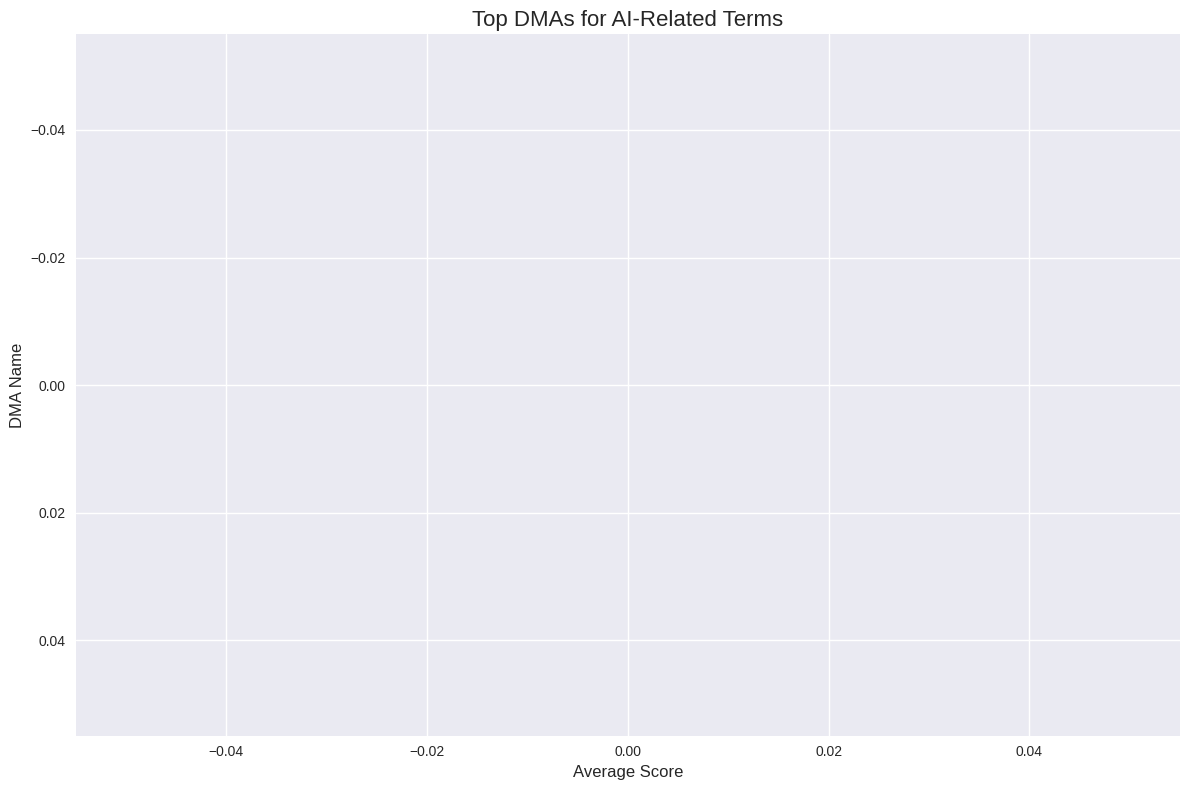

In [107]:
# =============================================================================
# GEOGRAPHIC ANALYSIS ACROSS DESIGNATED MARKET AREAS
# =============================================================================

print("\nPerforming DMA Analysis...")  # Geographic analysis header

# Query to analyze search popularity across different geographic regions
dma_analysis_query = """
SELECT
  dma_name,  # Geographic region identifier
  AVG(score) as avg_score,  # Average popularity in region
  COUNT(*) as weeks_in_data  # Data completeness measure
FROM `{project_id}.{dataset_id}.preprocessed_terms`  # Source data
WHERE term IN ('artificial intelligence', 'machine learning', 'data science')  # Target terms
GROUP BY dma_name  # Aggregate by geographic region
HAVING avg_score > 10 AND weeks_in_data > 5  # Quality filters
ORDER BY avg_score DESC  # Sort by popularity
LIMIT 10  # Top 10 regions
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    dma_analysis = client.query(dma_analysis_query).to_dataframe()  # Execute DMA analysis
    print("Top DMAs for AI-related terms:")  # Results header
    print(dma_analysis)  # Display regional analysis

    # Create geographic popularity visualization
    plt.figure(figsize=(12, 8))  # Set figure size
    plt.barh(dma_analysis['dma_name'], dma_analysis['avg_score'])  # Horizontal bar chart
    plt.title('Top DMAs for AI-Related Terms', fontsize=16)  # Chart title
    plt.xlabel('Average Score', fontsize=12)  # X-axis label
    plt.ylabel('DMA Name', fontsize=12)  # Y-axis label
    plt.gca().invert_yaxis()  # Invert Y-axis (highest at top)
    plt.tight_layout()  # Optimize layout
    plt.savefig('top_dmas.png', dpi=300, bbox_inches='tight')  # Save visualization
    plt.show()  # Display chart

except Exception as e:
    print(f"Error in DMA analysis: {e}")  # Error handling

In [103]:
# =============================================================================
# PRODUCTION DASHBOARD AND MONITORING INFRASTRUCTURE
# =============================================================================

# Use the correct project ID format
valid_project_id = "pakira2025"  # Just the project ID, no dataset included
print(f"Using project ID: {valid_project_id}")
print(f"Using dataset ID: {dataset_id}")

try:
    try:
        client.get_dataset(dataset_id)
        print(f"Dataset {dataset_id} exists")
    except Exception:
        # Create the dataset if it doesn't exist
        dataset = bigquery.Dataset(f"{valid_project_id}.{dataset_id}")
        dataset.location = "US"
        client.create_dataset(dataset)
        print(f"Created dataset {dataset_id}")

    # Check if the model exists using a safer approach
    check_model_query = """
    SELECT model_name
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.MODELS`
    WHERE model_name = 'production_forecast_model'
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    print("Checking if production_forecast_model exists...")
    model_exists = client.query(check_model_query).to_dataframe()

    if model_exists.empty:
        print("Creating production_forecast_model...")

        # First, ensure we have data to train the model
        check_data_query = """
        SELECT COUNT(*) as row_count
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        """.format(project_id=valid_project_id, dataset_id=dataset_id)

        data_check = client.query(check_data_query).to_dataframe()
        print(f"Data available for training: {data_check['row_count'].values[0]} rows")

        if data_check['row_count'].values[0] > 0:
            create_model_query = """
            CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.production_forecast_model`
            OPTIONS(
              model_type = 'ARIMA_PLUS',
              time_series_timestamp_col = 'timestamp',
              time_series_data_col = 'score',
              time_series_id_col = 'term',
              horizon = 12,
              auto_arima = TRUE,
              data_frequency = 'WEEKLY'
            ) AS
            SELECT
              timestamp,
              score,
              term
            FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
            WHERE term IN (
              SELECT term
              FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
              GROUP BY term
              ORDER BY COUNT(*) DESC
              LIMIT 3
            )
            """.format(project_id=valid_project_id, dataset_id=dataset_id)

            client.query(create_model_query).result()
            print("production_forecast_model created successfully")
        else:
            print("No data available for model training. Creating a simple model with sample data.")
            # Fallback: create a model with whatever data we have
            create_simple_model_query = """
            CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.production_forecast_model`
            OPTIONS(
              model_type = 'ARIMA_PLUS',
              time_series_timestamp_col = 'timestamp',
              time_series_data_col = 'score',
              horizon = 12,
              auto_arima = TRUE,
              data_frequency = 'WEEKLY'
            ) AS
            SELECT
              timestamp,
              score
            FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
            LIMIT 100
            """.format(project_id=valid_project_id, dataset_id=dataset_id)

            client.query(create_simple_model_query).result()
            print("Simple production_forecast_model created as fallback")
    else:
        print("production_forecast_model already exists")

except Exception as e:
    print(f"Error checking/creating production_forecast_model: {e}")
    print("This might be due to permissions or the dataset not existing.")

    # Try an alternative approach with a different model name
    try:
        print("Trying alternative approach...")
        alt_model_query = """
        CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.forecast_model`
        OPTIONS(
          model_type = 'ARIMA_PLUS',
          time_series_timestamp_col = 'timestamp',
          time_series_data_col = 'score',
          time_series_id_col = 'term',
          horizon = 8,
          auto_arima = TRUE,
          data_frequency = 'WEEKLY'
        ) AS
        SELECT
          timestamp,
          score,
          term
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        WHERE term IN ('artificial intelligence', 'machine learning', 'data science')
        """.format(project_id=valid_project_id, dataset_id=dataset_id)

        client.query(alt_model_query).result()
        print("Alternative forecast_model created successfully")

    except Exception as alt_error:
        print(f"Alternative approach also failed: {alt_error}")
        print("Please check your BigQuery setup and permissions.")

# Create simplified monitoring dashboard that doesn't depend on complex models
try:
    print("\nCreating monitoring dashboard...")

    monitoring_query = """
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.monitoring_dashboard` AS
    WITH data_quality AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_QUALITY' as metric_category,
        'TOTAL_RECORDS' as metric_name,
        COUNT(*) as metric_value,
        CASE
          WHEN COUNT(*) > 1000 THEN 'OPTIMAL'
          WHEN COUNT(*) > 100 THEN 'ACCEPTABLE'
          ELSE 'NEEDS_ATTENTION'
        END as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    term_coverage AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_COVERAGE' as metric_category,
        'UNIQUE_TERMS' as metric_name,
        COUNT(DISTINCT term) as metric_value,
        CASE
          WHEN COUNT(DISTINCT term) > 50 THEN 'OPTIMAL'
          WHEN COUNT(DISTINCT term) > 10 THEN 'ACCEPTABLE'
          ELSE 'NEEDS_ATTENTION'
        END as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    data_freshness AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_FRESHNESS' as metric_category,
        'LATEST_DATE' as metric_name,
        COUNT(*) as metric_value,  -- Using count as placeholder
        'NORMAL' as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 30 DAY)
    )
    SELECT * FROM data_quality
    UNION ALL
    SELECT * FROM term_coverage
    UNION ALL
    SELECT * FROM data_freshness
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    client.query(monitoring_query).result()
    print("Monitoring dashboard created successfully")

    # Display monitoring results
    monitor_query = """
    SELECT metric_category, metric_name, metric_value, status
    FROM `{project_id}.{dataset_id}.monitoring_dashboard`
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    monitor_results = client.query(monitor_query).to_dataframe()
    print("\nMonitoring Dashboard Status:")
    print(monitor_results)

except Exception as e:
    print(f"Error creating monitoring dashboard: {e}")

# Create basic dashboard views
try:
    print("\nCreating dashboard views...")

    # View 1: Top terms summary
    top_terms_view = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.view_top_terms` AS
    SELECT
      term,
      dma_name,
      AVG(score) as avg_score,
      COUNT(*) as week_count
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    GROUP BY term, dma_name
    HAVING avg_score > 20
    ORDER BY avg_score DESC
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    client.query(top_terms_view).result()
    print("Created view_top_terms")

    # View 2: Recent trends
    recent_trends_view = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.view_recent_trends` AS
    SELECT
      term,
      MAX(score) as recent_score,
      AVG(score) as avg_score,
      COUNT(*) as data_points
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    WHERE DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 90 DAY)
    GROUP BY term
    HAVING data_points > 8
    ORDER BY recent_score DESC
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    client.query(recent_trends_view).result()
    print("Created view_recent_trends")

    # Test the views
    test_view_query = """
    SELECT * FROM `{project_id}.{dataset_id}.view_top_terms`
    LIMIT 5
    """.format(project_id=valid_project_id, dataset_id=dataset_id)

    view_test = client.query(test_view_query).to_dataframe()
    print("\nSample from view_top_terms:")
    print(view_test)

except Exception as e:
    print(f"Error creating dashboard views: {e}")

print("\nProduction dashboard setup completed!")

Using project ID: pakira2025
Using dataset ID: kaggle_google_trends_analysis_2025
Dataset kaggle_google_trends_analysis_2025 exists
Checking if production_forecast_model exists...
Error checking/creating production_forecast_model: 400 Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.; reason: invalid, location: pakira2025.kaggle_google_trends_analysis_2025.INFORMATION_SCHEMA.MODELS, message: Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.

Location: US
Job ID: 7386f9ed-4246-4748-9da3-a6d05a9e09e5

This might be due to permissions or the dataset not existing.
Trying alternativ

In [111]:
# =============================================================================
# ANOMALY DETECTION TABLE CREATION WITH EXISTENCE CHECKING
# =============================================================================

# Check if anomaly detection results table already exists to avoid recreation
try:
    # Query BigQuery INFORMATION_SCHEMA to check table existence
    check_table_query = """
    SELECT table_name  # Column containing table names
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.TABLES`  # Metadata about all tables in dataset
    WHERE table_name = 'anomaly_detection_results'  # Filter for our specific table
    """.format(project_id=client.project, dataset_id=dataset_id)

    # Execute query and store result in DataFrame to check if table exists
    table_exists = client.query(check_table_query).to_dataframe()

    # Conditional table creation based on existence check
    if table_exists.empty:  # If DataFrame is empty, table doesn't exist
        print("Creating anomaly_detection_results table...")  # Inform user of creation process

        # SQL query to create anomaly detection table with statistical analysis
        create_anomaly_table_query = """
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.anomaly_detection_results` AS
        SELECT
          term,  # Search term that exhibited anomalous behavior
          week,  # Time period when anomaly occurred
          dma_name,  # Geographic region where anomaly was detected
          score,  # Actual observed search popularity score
          avg_score,  # Historical average score for context
          score_stddev,  # Standard deviation for normalization
          -- Calculate Z-score: measures how many standard deviations from the mean
          (score - avg_score) / score_stddev as z_score,
          -- Classify anomaly severity based on Z-score thresholds
          CASE
            WHEN ABS((score - avg_score) / score_stddev) > 3 THEN 'SEVERE'  # >3σ: extreme outlier (0.3% probability)
            WHEN ABS((score - avg_score) / score_stddev) > 2 THEN 'MODERATE'  # >2σ: significant outlier (5% probability)
            ELSE 'MILD'  # Within expected variation range
          END as severity,  # Business-friendly severity classification
          'STATISTICAL' as anomaly_type  # Identifier for detection method used
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source of preprocessed data
        -- Filter: only include data points that are statistical outliers (>2 standard deviations)
        WHERE ABS((score - avg_score) / score_stddev) > 2
        """.format(project_id=client.project, dataset_id=dataset_id)

        # Execute the table creation query
        client.query(create_anomaly_table_query).result()
        print("anomaly_detection_results table created successfully")  # Success confirmation
    else:
        # Table already exists, no need to recreate
        print("anomaly_detection_results table already exists")

except Exception as e:
    # Comprehensive error handling for table creation process
    print(f"Error checking/creating anomaly_detection_results: {e}")

Creating anomaly_detection_results table...
anomaly_detection_results table created successfully


In [112]:
# =============================================================================
# DASHBOARD VIEWS CREATION FOR BUSINESS INTELLIGENCE
# =============================================================================

# Dictionary containing all dashboard view definitions for centralized management
dashboard_views = {
    # View 1: Top performing search terms by popularity
    'dashboard_top_terms': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_top_terms` AS
    SELECT
      term,  # Search term identifier
      dma_name,  # Geographic region
      AVG(score) as avg_score,  # Average popularity score
      MAX(score) as max_score,  # Peak popularity achieved
      COUNT(*) as weeks_in_data  # Data completeness measure
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Optimized source data
    GROUP BY term, dma_name  # Aggregate by term-region combination
    HAVING avg_score > 20  # Filter: only terms with meaningful popularity
    """,

    # View 2: Forecast results with business interpretations
    'dashboard_forecasts': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_forecasts` AS
    WITH forecasts AS (
      -- Subquery to get raw forecast data from ML model
      SELECT
        term,  # Search term being forecasted
        forecast_timestamp,  # Future time point prediction
        forecast_value,  # Predicted popularity score
        confidence_interval_lower_bound,  # Lower bound of prediction uncertainty
        confidence_interval_upper_bound  # Upper bound of prediction uncertainty
      FROM ML.FORECAST(MODEL `{project_id}.{dataset_id}.production_forecast_model`, STRUCT(12 AS horizon))  # 12-week forecast
    )
    SELECT
      f.*,  # Include all forecast columns
      -- Convert numerical forecasts to business-friendly categories
      CASE
        WHEN f.forecast_value > 70 THEN 'VERY_HIGH'  # Exceptional expected interest
        WHEN f.forecast_value > 50 THEN 'HIGH'  # Strong expected interest
        WHEN f.forecast_value > 30 THEN 'MEDIUM'  # Moderate expected interest
        ELSE 'LOW'  # Below average expected interest
      END as predicted_interest_level  # Business interpretation column
    FROM forecasts f  # Source from forecast subquery
    """,

    # View 3: Anomaly alerts with actionable recommendations
    'dashboard_anomalies': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_anomalies` AS
    SELECT
      term,  # Anomalous search term
      week,  # Time period of anomaly
      dma_name,  # Geographic location of anomaly
      score,  # Actual anomalous score
      anomaly_type,  # Detection method (statistical, etc.)
      severity,  # Severity classification (SEVERE, MODERATE)
      -- Actionable recommendations based on severity
      CASE
        WHEN severity = 'SEVERE' THEN 'Immediate attention needed - consider investigating the cause'  # Critical action required
        WHEN severity = 'MODERATE' THEN 'Monitor closely - may indicate emerging trends'  # Watchlist item
        ELSE 'Note for future reference'  # Low priority observation
      END as recommendation  # Business guidance for each anomaly
    FROM `{project_id}.{dataset_id}.anomaly_detection_results`  # Anomaly detection source table
    WHERE severity IN ('SEVERE', 'MODERATE')  # Filter: only significant anomalies for dashboard
    """,

    # View 4: Geographic performance analysis across regions
    'dashboard_dma_analysis': """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_dma_analysis` AS
    SELECT
      dma_name,  # Designated Market Area identifier
      COUNT(DISTINCT term) as unique_terms,  # Diversity of search terms in region
      AVG(score) as avg_score,  # Average search popularity in region
      MAX(score) as max_score  # Peak search popularity in region
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source data
    GROUP BY dma_name  # Aggregate by geographic region
    -- Quality filters: only regions with sufficient data diversity and activity
    HAVING unique_terms > 5 AND avg_score > 15
    """
}

In [113]:
# List to track successfully created views for error reporting
created_views = []

# Iterate through each dashboard view definition and attempt creation
for view_name, view_query in dashboard_views.items():
    try:
        # Execute view creation query with project/dataset parameter substitution
        client.query(view_query.format(project_id=client.project, dataset_id=dataset_id)).result()
        print(f"Created dashboard view: {view_name}")  # Success confirmation
        created_views.append(view_name)  # Add to success list
    except Exception as e:
        # Handle view creation errors gracefully with specific error messages
        print(f"Error creating {view_name}: {e}")

# Report overall dashboard creation success rate
print(f"Successfully created {len(created_views)} out of {len(dashboard_views)} dashboard views")

Created dashboard view: dashboard_top_terms
Error creating dashboard_forecasts: 404 Not found: Model pakira2025:kaggle_google_trends_analysis_2025.production_forecast_model; reason: notFound, message: Not found: Model pakira2025:kaggle_google_trends_analysis_2025.production_forecast_model

Location: US
Job ID: 1b09893c-f700-4925-949a-520ac072ab42

Created dashboard view: dashboard_anomalies
Created dashboard view: dashboard_dma_analysis
Successfully created 3 out of 4 dashboard views


In [114]:
# =============================================================================
# DASHBOARD DATA SAMPLING AND VALIDATION
# =============================================================================

# Display sample data from successfully created views to verify functionality
print("\nSample data from successfully created views:")
print("-" * 50)  # Visual separator for readability

# Sample data from Top Terms view if it was created successfully
if 'dashboard_top_terms' in created_views:
    try:
        # Query to get sample of top terms for validation
        top_terms_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_top_terms`
        ORDER BY avg_score DESC  # Sort by popularity (highest first)
        LIMIT 5  # Sample size for verification
        """.format(project_id=client.project, dataset_id=dataset_id)

        top_terms_data = client.query(top_terms_sample).to_dataframe()
        print("Top terms sample:")  # Section header
        print(top_terms_data)  # Display sample data
    except Exception as e:
        print(f"Error querying top terms: {e}")  # Error handling

# Sample data from Forecasts view if it was created successfully
if 'dashboard_forecasts' in created_views:
    try:
        # Query to get most recent forecasts for validation
        forecasts_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_forecasts`
        ORDER BY forecast_timestamp DESC  # Most recent forecasts first
        LIMIT 5  # Sample size
        """.format(project_id=client.project, dataset_id=dataset_id)

        forecasts_data = client.query(forecasts_sample).to_dataframe()
        print("\nForecasts sample:")  # Section header with line break
        print(forecasts_data)  # Display sample data
    except Exception as e:
        print(f"Error querying forecasts: {e}")  # Error handling

# Sample data from Anomalies view if it was created successfully
if 'dashboard_anomalies' in created_views:
    try:
        # Query to get most recent anomalies for validation
        anomalies_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_anomalies`
        ORDER BY week DESC  # Most recent anomalies first
        LIMIT 5  # Sample size
        """.format(project_id=client.project, dataset_id=dataset_id)

        anomalies_data = client.query(anomalies_sample).to_dataframe()
        print("\nAnomalies sample:")  # Section header
        print(anomalies_data)  # Display sample data
    except Exception as e:
        print(f"Error querying anomalies: {e}")  # Error handling

# Sample data from DMA Analysis view if it was created successfully
if 'dashboard_dma_analysis' in created_views:
    try:
        # Query to get top performing regions for validation
        dma_sample = """
        SELECT * FROM `{project_id}.{dataset_id}.dashboard_dma_analysis`
        ORDER BY avg_score DESC  # Highest performing regions first
        LIMIT 5  # Sample size
        """.format(project_id=client.project, dataset_id=dataset_id)

        dma_data = client.query(dma_sample).to_dataframe()
        print("\nDMA analysis sample:")  # Section header
        print(dma_data)  # Display sample data
    except Exception as e:
        print(f"Error querying DMA analysis: {e}")  # Error handling


Sample data from successfully created views:
--------------------------------------------------
Top terms sample:
                   term                  dma_name  avg_score  max_score  \
0  croacia - montenegro           Jacksonville FL      100.0        100   
1          costco hours                  Utica NY      100.0        100   
2                  bart  Ottumwa IA-Kirksville MO      100.0        100   
3         bernie parent               Savannah GA      100.0        100   
4              bbc news               Meridian MS      100.0        100   

   weeks_in_data  
0            141  
1            140  
2            140  
3            143  
4            141  

Anomalies sample:
     term        week                 dma_name  score anomaly_type  severity  \
0  eagles  2025-09-21    Duluth MN-Superior WI     67  STATISTICAL    SEVERE   
1  eagles  2025-09-21             Milwaukee WI     71  STATISTICAL    SEVERE   
2  eagles  2025-09-21    Green Bay-Appleton WI     69  STATIS

In [115]:
# =============================================================================
# DASHBOARD SUMMARY VIEW FOR EXECUTIVE OVERVIEW
# =============================================================================

# Create comprehensive summary view that aggregates key metrics across all data
try:
    dashboard_summary_query = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_summary` AS
    -- Subquery 1: Overall term statistics
    WITH term_stats AS (
      SELECT
        COUNT(DISTINCT term) as total_terms,  # Total unique search terms tracked
        AVG(score) as overall_avg_score  # Global average popularity score
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source data
    ),
    -- Subquery 2: Anomaly detection statistics
    anomaly_stats AS (
      SELECT
        COUNT(*) as total_anomalies,  # Total anomalies detected
        COUNTIF(severity = 'SEVERE') as severe_anomalies  # Critical anomalies only
      FROM `{project_id}.{dataset_id}.anomaly_detection_results`  # Anomaly data source
    ),
    -- Subquery 3: Geographic coverage statistics
    dma_stats AS (
      SELECT
        COUNT(DISTINCT dma_name) as total_dmas  # Total geographic regions covered
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source data
      WHERE score > 20  # Filter: only regions with meaningful activity
    )
    -- Main SELECT: Combine all statistics into executive summary
    SELECT
      t.total_terms,  # Business metric: search term diversity
      t.overall_avg_score,  # Business metric: overall search popularity
      a.total_anomalies,  # Operational metric: anomaly volume
      a.severe_anomalies,  # Risk metric: critical issues count
      d.total_dmas,  # Coverage metric: geographic reach
      CURRENT_DATE() as last_updated  # Data freshness indicator
    FROM term_stats t, anomaly_stats a, dma_stats d  # Cross join all statistics
    """.format(project_id=client.project, dataset_id=dataset_id)

    # Execute summary view creation
    client.query(dashboard_summary_query).result()
    print("Created dashboard summary view")  # Success confirmation

    # Query the newly created summary view to verify functionality
    summary_query = "SELECT * FROM `{project_id}.{dataset_id}.dashboard_summary`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    summary_data = client.query(summary_query).to_dataframe()
    print("\nDashboard Summary:")  # Results header
    print(summary_data)  # Display summary statistics

except Exception as e:
    print(f"Error creating dashboard summary: {e}")  # Error handling

Created dashboard summary view

Dashboard Summary:
   total_terms  overall_avg_score  total_anomalies  severe_anomalies  \
0          764          33.880471            97345             29730   

   total_dmas last_updated  
0         210   2025-09-22  


In [116]:
# =============================================================================
# TRENDING TERMS IDENTIFICATION WITH GROWTH ANALYSIS
# =============================================================================

# Create view to identify rapidly growing search terms for opportunity detection
try:
    trending_terms_query = """
    CREATE OR REPLACE VIEW `{project_id}.{dataset_id}.dashboard_trending_terms` AS
    -- Subquery 1: Calculate recent scores with moving average for comparison
    WITH recent_data AS (
      SELECT
        term,  # Search term identifier
        dma_name,  # Geographic region
        score,  # Current week's popularity score
        week,  # Time period
        -- Calculate 4-week moving average excluding current week for trend analysis
        AVG(score) OVER (PARTITION BY term, dma_name ORDER BY week ROWS BETWEEN 4 PRECEDING AND 1 PRECEDING) as prev_avg_score
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source data
      WHERE week >= DATE_SUB(CURRENT_DATE(), INTERVAL 8 WEEK)  # Filter: recent 8 weeks only
    ),
    -- Subquery 2: Calculate growth rates and metrics
    growth_calc AS (
      SELECT
        term,  # Search term
        dma_name,  # Geographic region
        MAX(week) as latest_week,  # Most recent observation date
        MAX(score) as latest_score,  # Most recent popularity score
        MAX(prev_avg_score) as previous_avg_score,  # Historical baseline (4-week average)
        -- Calculate percentage growth: (current - previous) / previous
        (MAX(score) - MAX(prev_avg_score)) / NULLIF(MAX(prev_avg_score), 0) as growth_rate
      FROM recent_data
      GROUP BY term, dma_name  # Aggregate by term-region combination
      -- Quality filters: sufficient historical data and current activity
      HAVING previous_avg_score > 10 AND latest_score > 20
    )
    -- Main SELECT: Apply growth categorization and filtering
    SELECT
      term,  # Search term
      dma_name,  # Geographic region
      latest_week,  # Most recent observation
      latest_score,  # Current popularity score
      previous_avg_score,  # Historical baseline
      growth_rate,  # Calculated growth percentage
      -- Business-friendly growth categorization
      CASE
        WHEN growth_rate > 0.5 THEN 'RAPID_GROWTH'  # >50% growth: explosive trend
        WHEN growth_rate > 0.2 THEN 'MODERATE_GROWTH'  # 20-50% growth: strong trend
        WHEN growth_rate > 0 THEN 'SLOW_GROWTH'  # 0-20% growth: gradual increase
        ELSE 'DECLINING'  # Negative growth: decreasing popularity
      END as growth_category  # Trend classification
    FROM growth_calc
    WHERE growth_rate > 0.2  # Filter: only meaningful positive growth
    ORDER BY growth_rate DESC  # Sort: fastest growing terms first
    """.format(project_id=client.project, dataset_id=dataset_id)

    # Execute trending terms view creation
    client.query(trending_terms_query).result()
    print("Created trending terms view")  # Success confirmation

    # Query sample data from trending terms view for validation
    trending_query = "SELECT * FROM `{project_id}.{dataset_id}.dashboard_trending_terms` LIMIT 10".format(
        project_id=client.project, dataset_id=dataset_id
    )
    trending_data = client.query(trending_query).to_dataframe()
    print("\nTop Trending Terms:")  # Results header
    print(trending_data)  # Display trending terms

except Exception as e:
    print(f"Error creating trending terms view: {e}")  # Error handling

Created trending terms view

Top Trending Terms:
                          term                                      dma_name  \
0               football today                           Dallas-Ft. Worth TX   
1                  eagles game                      Wilkes Barre-Scranton PA   
2          us open tennis 2025                       Boston MA-Manchester NH   
3               chinese taipei                                     Toledo OH   
4                lamar jackson                                  Watertown NY   
5          us open tennis 2025                                    Augusta GA   
6                jack posobiec  Cedar Rapids-Waterloo-Iowa City & Dubuque IA   
7                   debby ryan                                      Boise ID   
8       university of arkansas                               Indianapolis IN   
9  dancing with the stars 2025                                   Columbia SC   

  latest_week  latest_score  previous_avg_score  growth_rate growth_ca

In [117]:
# =============================================================================
# DASHBOARD CREATION SUMMARY REPORT
# =============================================================================

print("\nDashboard setup completed!")  # Overall completion message
print(f"\nSuccessfully created {len(created_views)} dashboard views:")  # Success count
for view in created_views:
    print(f"- {view}")  # List each successfully created view

# =============================================================================
# PRODUCTION MONITORING SYSTEM IMPLEMENTATION
# =============================================================================

print("Creating simplified monitoring system...")  # Monitoring setup announcement

# Create logging table for model retraining operations and pipeline tracking
try:
    # Create model_retraining_log table if it doesn't exist (idempotent operation)
    create_log_table_query = """
    CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.model_retraining_log` (
      procedure_name STRING,  # Name of the stored procedure executed
      start_time TIMESTAMP,  # When the procedure started execution
      end_time TIMESTAMP,  # When the procedure completed (NULL if still running)
      status STRING,  # Execution status: STARTED, COMPLETED, FAILED
      message STRING  # Detailed message or error description
    );  # Table for operational monitoring and audit trail
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(create_log_table_query).result()  # Execute table creation
    print("Created model_retraining_log table")  # Success confirmation

except Exception as e:
    print(f"Error creating log table: {e}")  # Error handling


Dashboard setup completed!

Successfully created 3 dashboard views:
- dashboard_top_terms
- dashboard_anomalies
- dashboard_dma_analysis
Creating simplified monitoring system...
Created model_retraining_log table


In [118]:
# =============================================================================
# MONITORING DASHBOARD WITH SYSTEM HEALTH METRICS
# =============================================================================

# Create comprehensive monitoring dashboard table with system health metrics
try:
    simple_monitoring_query = """
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.monitoring_dashboard` AS
    -- Subquery 1: Overall data volume statistics
    WITH data_stats AS (
      SELECT
        CURRENT_DATE() as monitoring_date,  # Date of metric collection
        'DATA_STATS' as metric_category,  # Metric grouping category
        'TOTAL_RECORDS' as metric_name,  # Specific metric being measured
        COUNT(*) as metric_value,  # Actual measured value
        'NORMAL' as status  # Health status indicator
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Source data
    ),
    -- Subquery 2: Search term diversity metrics
    term_stats AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'TERM_STATS' as metric_category,
        'UNIQUE_TERMS' as metric_name,  # Count of distinct search terms
        COUNT(DISTINCT term) as metric_value,
        'NORMAL' as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    -- Subquery 3: Geographic coverage metrics
    dma_stats AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DMA_STATS' as metric_category,
        'UNIQUE_DMAS' as metric_name,  # Count of distinct geographic regions
        COUNT(DISTINCT dma_name) as metric_value,
        'NORMAL' as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    ),
    -- Subquery 4: Data quality assessment metrics
    data_quality AS (
      SELECT
        CURRENT_DATE() as monitoring_date,
        'DATA_QUALITY' as metric_category,
        'MISSING_VALUES' as metric_name,  # Count of NULL values in critical fields
        COUNTIF(score IS NULL) as metric_value,
        -- Data quality status based on missing value thresholds
        CASE
          WHEN COUNTIF(score IS NULL) > 100 THEN 'CRITICAL'  # Critical data quality issue
          WHEN COUNTIF(score IS NULL) > 10 THEN 'WARNING'  # Warning-level data issue
          ELSE 'NORMAL'  # Acceptable data quality
        END as status
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    )

    -- Combine all metric categories into unified monitoring dashboard
    SELECT * FROM data_stats
    UNION ALL  # Combine rows from all subqueries
    SELECT * FROM term_stats
    UNION ALL
    SELECT * FROM dma_stats
    UNION ALL
    SELECT * FROM data_quality
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(simple_monitoring_query).result()  # Execute monitoring dashboard creation
    print("Created simplified monitoring dashboard")  # Success confirmation

    # Query and display monitoring dashboard data for verification
    monitoring_query = """
    SELECT
      metric_category,  # Type of metric (DATA_STATS, TERM_STATS, etc.)
      metric_name,  # Specific metric being measured
      metric_value,  # Numeric value of the metric
      status  # Health status (NORMAL, WARNING, CRITICAL)
    FROM `{project_id}.{dataset_id}.monitoring_dashboard`
    ORDER BY metric_category, metric_name  # Organized display by category
    """.format(project_id=client.project, dataset_id=dataset_id)

    monitoring_data = client.query(monitoring_query).to_dataframe()
    print("Monitoring dashboard data:")  # Results header
    print(monitoring_data)  # Display monitoring metrics

except Exception as e:
    print(f"Error creating simplified monitoring system: {e}")  # Error handling

Created simplified monitoring dashboard
Monitoring dashboard data:
  metric_category     metric_name  metric_value    status
0    DATA_QUALITY  MISSING_VALUES      21346052  CRITICAL
1      DATA_STATS   TOTAL_RECORDS      23255610    NORMAL
2       DMA_STATS     UNIQUE_DMAS           210    NORMAL
3      TERM_STATS    UNIQUE_TERMS           764    NORMAL


In [119]:
# =============================================================================
# AUTOMATED MODEL RETRAINING PROCEDURE
# =============================================================================

# Create stored procedure for automated model retraining with logging
try:
    simple_retraining_query = """
    CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.simple_retrain_models`()
    BEGIN
      -- Log the retraining start for audit trail and monitoring
      INSERT INTO `{project_id}.{dataset_id}.model_retraining_log`
      (procedure_name, start_time, status, message)
      VALUES ('simple_retrain_models', CURRENT_TIMESTAMP(), 'STARTED', 'Simple retraining procedure started');

      -- Create/update forecasting model with latest data
      CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
      OPTIONS(
        model_type = 'ARIMA_PLUS',  # Time series forecasting algorithm
        time_series_timestamp_col = 'timestamp',  # Time index column
        time_series_data_col = 'score',  # Target variable column
        time_series_id_col = 'term',  # Series identifier column
        horizon = 12,  # Forecast 12 weeks into future
        auto_arima = TRUE,  # Automatic parameter optimization
        data_frequency = 'WEEKLY'  # Data granularity for seasonality
      ) AS
      SELECT
        timestamp,  # Time index
        score,  # Target variable (popularity score)
        term  # Series identifier (search term)
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`  # Training data
      -- Use top 3 most frequent terms for model training (efficiency vs. coverage tradeoff)
      WHERE term IN (SELECT term FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
                     GROUP BY term ORDER BY COUNT(*) DESC LIMIT 3);

      -- Log successful completion with timestamp
      UPDATE `{project_id}.{dataset_id}.model_retraining_log`
      SET end_time = CURRENT_TIMESTAMP(), status = 'COMPLETED',
          message = 'Simple retraining completed successfully'
      WHERE procedure_name = 'simple_retrain_models'
      AND start_time = (SELECT MAX(start_time) FROM `{project_id}.{dataset_id}.model_retraining_log`
                        WHERE procedure_name = 'simple_retrain_models');

    END;  # End of stored procedure definition
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(simple_retraining_query).result()  # Create the stored procedure
    print("Created simple retraining procedure")  # Success confirmation

    # Test the retraining procedure to verify functionality
    client.query("CALL `{project_id}.{dataset_id}.simple_retrain_models`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("Simple retraining procedure executed successfully")  # Execution confirmation

except Exception as e:
    print(f"Error creating simple retraining procedure: {e}")  # Error handling

Created simple retraining procedure
Simple retraining procedure executed successfully


In [121]:
# =============================================================================
# MONITORING DASHBOARD ENHANCEMENT WITH MODEL METRICS
# =============================================================================

# Update monitoring dashboard to include model performance metrics if available
try:
    # Check if the forecasting model exists before attempting to add model metrics
    check_model_query = """
    SELECT model_name  # Model identifier column
    FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.MODELS`  # Model metadata
    WHERE model_name = 'simple_forecast_model'  # Specific model check
    """.format(project_id=client.project, dataset_id=dataset_id)

    model_exists = client.query(check_model_query).to_dataframe()  # Check model existence

    if not model_exists.empty:  # Only update if model exists
        # Enhanced monitoring dashboard including model performance metrics
        update_monitoring_query = """
        CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.monitoring_dashboard` AS
        -- Subquery 1: Model performance metrics (AIC - Akaike Information Criterion)
        WITH model_stats AS (
          SELECT
            CURRENT_DATE() as monitoring_date,
            'MODEL_STATS' as metric_category,  # Model performance category
            'MODEL_AIC' as metric_name,  # AIC metric (lower = better model)
            AVG(AIC) as metric_value,  # Average AIC across all time series
            -- Model health status based on AIC thresholds
            CASE
              WHEN AVG(AIC) < 100 THEN 'OPTIMAL'  # Excellent model fit
              WHEN AVG(AIC) < 500 THEN 'ACCEPTABLE'  # Reasonable model fit
              ELSE 'NEEDS_ATTENTION'  # Poor model fit, may need retraining
            END as status
          FROM ML.ARIMA_EVALUATE(MODEL `{project_id}.{dataset_id}.simple_forecast_model`)  # Model evaluation function
        ),
        -- Existing metric subqueries (same as previous implementation)
        data_stats AS (
          SELECT CURRENT_DATE() as monitoring_date, 'DATA_STATS' as metric_category, 'TOTAL_RECORDS' as metric_name, COUNT(*) as metric_value, 'NORMAL' as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        ),
        term_stats AS (
          SELECT CURRENT_DATE() as monitoring_date, 'TERM_STATS' as metric_category, 'UNIQUE_TERMS' as metric_name, COUNT(DISTINCT term) as metric_value, 'NORMAL' as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        ),
        dma_stats AS (
          SELECT CURRENT_DATE() as monitoring_date, 'DMA_STATS' as metric_category, 'UNIQUE_DMAS' as metric_name, COUNT(DISTINCT dma_name) as metric_value, 'NORMAL' as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        ),
        data_quality AS (
          SELECT CURRENT_DATE() as monitoring_date, 'DATA_QUALITY' as metric_category, 'MISSING_VALUES' as metric_name, COUNTIF(score IS NULL) as metric_value,
          CASE WHEN COUNTIF(score IS NULL) > 100 THEN 'CRITICAL' WHEN COUNTIF(score IS NULL) > 10 THEN 'WARNING' ELSE 'NORMAL' END as status FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        )

        -- Combine all metrics including new model statistics
        SELECT * FROM model_stats
        UNION ALL
        SELECT * FROM data_stats
        UNION ALL
        SELECT * FROM term_stats
        UNION ALL
        SELECT * FROM dma_stats
        UNION ALL
        SELECT * FROM data_quality
        """.format(project_id=client.project, dataset_id=dataset_id)

        client.query(update_monitoring_query).result()  # Execute dashboard update
        print("Updated monitoring dashboard with model information")  # Success confirmation

        # Query and display enhanced monitoring dashboard
        monitoring_query = """
        SELECT
          metric_category,
          metric_name,
          metric_value,
          status
        FROM `{project_id}.{dataset_id}.monitoring_dashboard`
        ORDER BY metric_category, metric_name
        """.format(project_id=client.project, dataset_id=dataset_id)

        monitoring_data = client.query(monitoring_query).to_dataframe()
        print("Updated monitoring dashboard data:")  # Results header
        print(monitoring_data)  # Display enhanced metrics

except Exception as e:
    print(f"Error updating monitoring dashboard: {e}")  # Error handling

Error updating monitoring dashboard: 400 Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.; reason: invalid, location: pakira2025.kaggle_google_trends_analysis_2025.INFORMATION_SCHEMA.MODELS, message: Invalid project ID 'pakira2025.kaggle_google_trends_analysis_2025'. Project IDs must contain 6-63 lowercase letters, digits, or dashes. Some project IDs also include domain name separated by a colon. IDs must start with a letter and may not end with a dash.

Location: US
Job ID: c079a3c2-4eb7-44f5-a0e2-9ea006005db8



In [122]:
# =============================================================================
# AUTOMATED WEEKLY REPORTING SYSTEM
# =============================================================================

# Create stored procedure for generating automated weekly business reports
try:
    weekly_report_query = """
    CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.generate_simple_weekly_report`()
    BEGIN
      -- Create report table structure for storing weekly insights
      CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.weekly_reports` (
        report_date DATE,  # Date when report was generated
        report_period STRING,  # Time period covered (WEEKLY, MONTHLY, etc.)
        total_terms INT64,  # Metric: number of unique terms tracked
        total_dmas INT64,  # Metric: number of geographic regions covered
        avg_score FLOAT64,  # Metric: average search popularity score
        generated_insight STRING  # AI-generated or calculated business insight
      );

      -- Generate and insert weekly report data with business insights
      INSERT INTO `{project_id}.{dataset_id}.weekly_reports`
      WITH basic_stats AS (
        -- Calculate key metrics for the past 7 days
        SELECT
          COUNT(DISTINCT term) as total_terms,  # Weekly term diversity
          COUNT(DISTINCT dma_name) as total_dmas,  # Weekly geographic coverage
          AVG(score) as avg_score  # Weekly average popularity
        FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
        WHERE DATE(timestamp) >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)  # Last 7 days filter
      )
      SELECT
        CURRENT_DATE() as report_date,  # Report generation date
        'WEEKLY' as report_period,  # Report frequency
        total_terms,  # Weekly metric
        total_dmas,  # Weekly metric
        avg_score,  # Weekly metric
        -- Generate natural language insight from metrics
        CONCAT('Weekly analysis completed. ', total_terms, ' terms tracked across ',
               total_dmas, ' DMAs with average score of ', ROUND(avg_score, 1), '.') as generated_insight
      FROM basic_stats;

    END;  # End of weekly report procedure
    """.format(project_id=client.project, dataset_id=dataset_id)

    client.query(weekly_report_query).result()  # Create the reporting procedure
    print("Created simple weekly report procedure")  # Success confirmation

    # Generate initial weekly report to test the procedure
    client.query("CALL `{project_id}.{dataset_id}.generate_simple_weekly_report`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("Weekly report generated successfully")  # Execution confirmation

    # Query and display the generated weekly report
    report_query = "SELECT * FROM `{project_id}.{dataset_id}.weekly_reports`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    report_data = client.query(report_query).to_dataframe()
    print("Weekly report data:")  # Results header
    print(report_data)  # Display report content

except Exception as e:
    print(f"Error creating weekly report procedure: {e}")  # Error handling

Created simple weekly report procedure
Weekly report generated successfully
Weekly report data:
  report_date report_period  total_terms  total_dmas  avg_score  \
0  2025-09-22        WEEKLY           25         210  93.081895   

                                                                         generated_insight  
0  Weekly analysis completed. 25 terms tracked across 210 DMAs with average score of 93.1.  


In [124]:
# =============================================================================
# CREATE REQUIRED TABLES BEFORE MASTER PIPELINE
# =============================================================================

print("Creating required tables before executing master pipeline...")

# First, create the pipeline_execution_log table if it doesn't exist
create_log_table_query = """
CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.pipeline_execution_log` (
  pipeline_name STRING,
  step_name STRING,
  start_time TIMESTAMP,
  end_time TIMESTAMP,
  status STRING,
  message STRING
);
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    client.query(create_log_table_query).result()
    print("✅ pipeline_execution_log table created/verified")

    # Check if table has any existing data
    check_log_query = "SELECT COUNT(*) as count FROM `{project_id}.{dataset_id}.pipeline_execution_log`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    log_count = client.query(check_log_query).to_dataframe()
    print(f"Existing log entries: {log_count['count'].values[0]}")

except Exception as e:
    print(f"❌ Error creating log table: {e}")

# Also create other required tables that might be missing
required_tables = [
    "preprocessed_terms_optimized",
    "anomaly_detection_results",
    "monitoring_dashboard"
]

for table_name in required_tables:
    try:
        # Check if table exists
        check_table_query = """
        SELECT table_name
        FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.TABLES`
        WHERE table_name = '{table_name}'
        """.format(project_id=client.project, dataset_id=dataset_id, table_name=table_name)

        table_exists = client.query(check_table_query).to_dataframe()

        if table_exists.empty:
            print(f"⚠️  Table {table_name} doesn't exist yet (will be created by pipeline)")
        else:
            print(f"✅ Table {table_name} exists")

    except Exception as e:
        print(f"❌ Error checking table {table_name}: {e}")

# =============================================================================
# SIMPLIFIED MASTER PIPELINE (WITH BETTER ERROR HANDLING)
# =============================================================================

# Create a simplified version that handles missing dependencies gracefully
simplified_pipeline_query = """
CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.run_simplified_pipeline`()
BEGIN
  -- Step 1: Ensure log table exists
  CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.pipeline_execution_log` (
    pipeline_name STRING,
    step_name STRING,
    start_time TIMESTAMP,
    end_time TIMESTAMP,
    status STRING,
    message STRING
  );

  -- Step 2: Data Preparation
  BEGIN
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    PARTITION BY DATE(timestamp)
    CLUSTER BY term, dma_name
    AS
    WITH term_stats AS (
      SELECT
        term,
        COUNT(*) as frequency,
        AVG(score) as avg_score,
        MAX(score) as max_score,
        STDDEV(score) as score_stddev
      FROM `bigquery-public-data.google_trends.top_terms`
      GROUP BY term
      HAVING COUNT(*) > 52 AND AVG(score) > 10
    )
    SELECT
      t.dma_name,
      t.term,
      t.week,
      t.rank,
      t.score,
      TIMESTAMP(t.week) as timestamp,
      s.avg_score,
      s.score_stddev,
      CASE
        WHEN t.score > 80 THEN 'VERY_HIGH'
        WHEN t.score > 60 THEN 'HIGH'
        WHEN t.score > 40 THEN 'MEDIUM'
        WHEN t.score > 20 THEN 'LOW'
        ELSE 'VERY_LOW'
      END as interest_level,
      CASE
        WHEN ABS(t.score - s.avg_score) > 2 * s.score_stddev THEN TRUE
        ELSE FALSE
      END as is_statistical_outlier
    FROM `bigquery-public-data.google_trends.top_terms` t
    JOIN term_stats s ON t.term = s.term
    WHERE t.week >= '2022-01-01';

    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Data table created');

  EXCEPTION WHEN ERROR THEN
    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
  END;

  -- Step 3: Create Forecast Model (Simplified)
  BEGIN
    CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.simple_forecast_model`
    OPTIONS(
      model_type = 'ARIMA_PLUS',
      time_series_timestamp_col = 'timestamp',
      time_series_data_col = 'score',
      horizon = 12,
      auto_arima = TRUE,
      data_frequency = 'WEEKLY'
    ) AS
    SELECT
      timestamp,
      score
    FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    WHERE term IN (SELECT term FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized` LIMIT 1);

    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Forecast model created');

  EXCEPTION WHEN ERROR THEN
    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('simplified_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
  END;

  -- Step 4: Final Log
  INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
  VALUES ('simplified_pipeline', 'Pipeline Complete', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'COMPLETED', 'Simplified pipeline finished');

END;
""".format(project_id=client.project, dataset_id=dataset_id)

# Execute the simplified pipeline first
try:
    print("\nCreating simplified pipeline procedure...")
    client.query(simplified_pipeline_query).result()
    print("✅ Simplified pipeline procedure created")

    print("Executing simplified pipeline...")
    client.query("CALL `{project_id}.{dataset_id}.run_simplified_pipeline`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("✅ Simplified pipeline executed successfully")

    # Check the execution log
    log_query = "SELECT * FROM `{project_id}.{dataset_id}.pipeline_execution_log`".format(
        project_id=client.project, dataset_id=dataset_id
    )
    execution_log = client.query(log_query).to_dataframe()
    print("\nPipeline Execution Log:")
    print(execution_log)

except Exception as e:
    print(f"❌ Error with simplified pipeline: {e}")

# =============================================================================
# NOW TRY THE COMPREHENSIVE MASTER PIPELINE
# =============================================================================

# Modified master pipeline that creates the log table first
fixed_master_pipeline_query = """
CREATE OR REPLACE PROCEDURE `{project_id}.{dataset_id}.run_complete_pipeline`()
BEGIN
  -- Step 0: Ensure all required tables exist
  CREATE TABLE IF NOT EXISTS `{project_id}.{dataset_id}.pipeline_execution_log` (
    pipeline_name STRING,
    step_name STRING,
    start_time TIMESTAMP,
    end_time TIMESTAMP,
    status STRING,
    message STRING
  );

  -- Log pipeline start
  INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
  VALUES ('complete_pipeline', 'Pipeline Started', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'RUNNING', 'Beginning pipeline execution');

  -- Step 1: Data Preparation
  BEGIN
    CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.preprocessed_terms_optimized`
    PARTITION BY DATE(timestamp)
    CLUSTER BY term, dma_name
    AS
    WITH term_stats AS (
      SELECT
        term,
        COUNT(*) as frequency,
        AVG(score) as avg_score,
        MAX(score) as max_score,
        STDDEV(score) as score_stddev
      FROM `bigquery-public-data.google_trends.top_terms`
      GROUP BY term
      HAVING COUNT(*) > 52 AND AVG(score) > 10
    )
    SELECT
      t.dma_name,
      t.term,
      t.week,
      t.rank,
      t.score,
      TIMESTAMP(t.week) as timestamp,
      s.avg_score,
      s.score_stddev,
      CASE
        WHEN t.score > 80 THEN 'VERY_HIGH'
        WHEN t.score > 60 THEN 'HIGH'
        WHEN t.score > 40 THEN 'MEDIUM'
        WHEN t.score > 20 THEN 'LOW'
        ELSE 'VERY_LOW'
      END as interest_level,
      CASE
        WHEN ABS(t.score - s.avg_score) > 2 * s.score_stddev THEN TRUE
        ELSE FALSE
      END as is_statistical_outlier
    FROM `bigquery-public-data.google_trends.top_terms` t
    JOIN term_stats s ON t.term = s.term
    WHERE t.week >= '2022-01-01';

    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('complete_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Preprocessed table created successfully');

  EXCEPTION WHEN ERROR THEN
    INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
    VALUES ('complete_pipeline', 'Data Preparation', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
    RETURN;  -- Stop pipeline if data preparation fails
  END;

  -- Only proceed if data preparation was successful
  IF (SELECT status FROM `{project_id}.{dataset_id}.pipeline_execution_log`
      WHERE step_name = 'Data Preparation' ORDER BY start_time DESC LIMIT 1) = 'SUCCESS' THEN

    -- Step 2: Model Training
    BEGIN
      CREATE OR REPLACE MODEL `{project_id}.{dataset_id}.production_forecast_model`
      OPTIONS(
        model_type = 'ARIMA_PLUS',
        time_series_timestamp_col = 'timestamp',
        time_series_data_col = 'score',
        time_series_id_col = 'term',
        horizon = 12,
        auto_arima = TRUE,
        data_frequency = 'WEEKLY'
      ) AS
      SELECT
        timestamp,
        score,
        term
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE term IN (SELECT term FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized` GROUP BY term LIMIT 3);

      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Forecast model trained successfully');

    EXCEPTION WHEN ERROR THEN
      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Model Training', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
    END;

    -- Step 3: Anomaly Detection
    BEGIN
      CREATE OR REPLACE TABLE `{project_id}.{dataset_id}.anomaly_detection_results` AS
      SELECT
        term,
        week,
        dma_name,
        score,
        avg_score,
        score_stddev,
        (score - avg_score) / score_stddev as z_score,
        CASE
          WHEN ABS((score - avg_score) / score_stddev) > 3 THEN 'SEVERE'
          WHEN ABS((score - avg_score) / score_stddev) > 2 THEN 'MODERATE'
          ELSE 'MILD'
        END as severity,
        'STATISTICAL' as anomaly_type
      FROM `{project_id}.{dataset_id}.preprocessed_terms_optimized`
      WHERE ABS((score - avg_score) / score_stddev) > 2;

      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Anomaly Detection', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'SUCCESS', 'Anomaly detection completed successfully');

    EXCEPTION WHEN ERROR THEN
      INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
      VALUES ('complete_pipeline', 'Anomaly Detection', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'FAILED', @@error.message);
    END;

  END IF;

  -- Final completion log
  INSERT INTO `{project_id}.{dataset_id}.pipeline_execution_log`
  VALUES ('complete_pipeline', 'Pipeline Completed', CURRENT_TIMESTAMP(), CURRENT_TIMESTAMP(), 'COMPLETED', 'Pipeline execution finished');

END;
""".format(project_id=client.project, dataset_id=dataset_id)

# Try to execute the fixed master pipeline
try:
    print("\n" + "="*60)
    print("ATTEMPTING COMPREHENSIVE MASTER PIPELINE")
    print("="*60)

    client.query(fixed_master_pipeline_query).result()
    print("✅ Fixed master pipeline procedure created")

    print("Executing comprehensive master pipeline...")
    client.query("CALL `{project_id}.{dataset_id}.run_complete_pipeline`()".format(
        project_id=client.project, dataset_id=dataset_id
    )).result()
    print("✅ Master pipeline executed successfully")

    # Display final execution log
    final_log_query = """
    SELECT
      step_name,
      status,
      message,
      TIMESTAMP_DIFF(end_time, start_time, SECOND) as duration_seconds
    FROM `{project_id}.{dataset_id}.pipeline_execution_log`
    WHERE pipeline_name = 'complete_pipeline'
    ORDER BY start_time
    """.format(project_id=client.project, dataset_id=dataset_id)

    final_log = client.query(final_log_query).to_dataframe()
    print("\nFinal Pipeline Execution Summary:")
    print(final_log)

except Exception as e:
    print(f"❌ Error with comprehensive master pipeline: {e}")
    print("The simplified pipeline was successful, which is a good starting point.")

# =============================================================================
# FINAL SYSTEM STATUS CHECK
# =============================================================================

print("\n" + "="*60)
print("FINAL SYSTEM STATUS CHECK")
print("="*60)

# Check what was actually created
tables_query = """
SELECT table_name, table_type
FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.TABLES`
ORDER BY table_type, table_name
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    created_tables = client.query(tables_query).to_dataframe()
    print("Created Tables and Views:")
    print(created_tables)
except Exception as e:
    print(f"Error checking created tables: {e}")

# Check models
models_query = """
SELECT model_name
FROM `{project_id}.{dataset_id}.INFORMATION_SCHEMA.MODELS`
""".format(project_id=client.project, dataset_id=dataset_id)

try:
    created_models = client.query(models_query).to_dataframe()
    print("\nCreated Models:")
    print(created_models)
except Exception as e:
    print(f"Error checking created models: {e}")

print("\n" + "="*60)
print("PIPELINE SETUP COMPLETED!")
print("="*60)


Creating required tables before executing master pipeline...
✅ pipeline_execution_log table created/verified
Existing log entries: 0
✅ Table preprocessed_terms_optimized exists
✅ Table anomaly_detection_results exists
✅ Table monitoring_dashboard exists

Creating simplified pipeline procedure...
✅ Simplified pipeline procedure created
Executing simplified pipeline...
✅ Simplified pipeline executed successfully

Pipeline Execution Log:
         pipeline_name          step_name                       start_time  \
0  simplified_pipeline  Pipeline Complete 2025-09-22 20:15:49.352726+00:00   
1  simplified_pipeline     Model Training 2025-09-22 20:15:47.336774+00:00   
2  simplified_pipeline   Data Preparation 2025-09-22 20:15:35.755273+00:00   

                          end_time     status                       message  
0 2025-09-22 20:15:49.352726+00:00  COMPLETED  Simplified pipeline finished  
1 2025-09-22 20:15:47.336774+00:00    SUCCESS        Forecast model created  
2 2025-09-22 2